In [774]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *
import plotly.graph_objects as go


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6],
                     })



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [775]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    return df
    
dfo = loaddata("data/pida.root", entry_stop=None, forceit=False)
df = loaddata("data/pida_shw.root", entry_stop=None, forceit=False)
dfshort = loaddata("data/pida_short.root", entry_stop=None, forceit=False)
# df = loaddata("data/pida_full_range.root", entry_stop=None, forceit=False)
# df = loaddata("data/pida_limited_stddev2.root", entry_stop=None, forceit=False)
df_lim = loaddata("data/pida_not_limited.root", entry_stop=None, forceit=False)
# df = loaddata("data/pida_before_llhd_not_limited.root", entry_stop=None, forceit=False)
# df_lim = loaddata("data/pida_limited.root", entry_stop=None)


data/pida.root loaded parquet
data/pida_shw.root loaded parquet
data/pida_short.root loaded parquet
data/pida_not_limited.root loaded parquet


In [776]:
def getbestof(df:pl.DataFrame ) -> pl.DataFrame:
    allkeys = df.columns
    allkeys = [ k.strip("_U") for k in allkeys if "_U" in k]
    for k in allkeys:
        vartomax = "trknhits_planes"
        if "trkpid" in k:
            vartomax='trkpidndf'
        if k.startswith('allcalo') or k.startswith("trkcalo"):
            vartomax='nallhits_planes'
        
        df = df.with_columns(
            pl.when(
                (pl.col(f'{vartomax}_W') >= pl.col(f'{vartomax}_V')) & 
                (pl.col(f'{vartomax}_W') >= pl.col(f'{vartomax}_U'))  
                ).then(
                    pl.col(f'{k}_W')
                ).otherwise(
                    pl.when(
                        (pl.col(f'{vartomax}_V') >= pl.col(f'{vartomax}_U'))  
                    ).then(
                        pl.col(f'{k}_V')
                    ).otherwise(
                        pl.col(f'{k}_U')
                    )
                ).alias(f"{k}_B")
        )
    return df

dftrkg4 = getbestof(df)
dftrkg4short = getbestof(dfshort)
dftrkg4 = dftrkg4.join(dftrkg4short.group_by(selection_events()).agg(), on=selection_events(), )
dftrkg4 = dftrkg4.join(dftrkg4short.select(selection_events('trkId', 'trkpidpida_B')), on=selection_events('trkId'), how='left', coalesce=True)
dftrkg4 = dftrkg4.with_columns(
    pl.col('trkpidpida_B_right').fill_null(-1).alias('trksmallpida')
).drop('trkpidpida_B_right')
dftrkg4 

run,subrun,event,nuPDG_truth,ccnc_truth,mode_truth,nuWeight_truth,enu_truth,vtxx_truth,vtxy_truth,vtxz_truth,recovtxx,recovtxy,recovtxz,lepen,lepmass,leppdg,lepid,ntracks,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4mother,trknhits,trkg4id_planes_U,trkg4id_planes_V,trkg4id_planes_W,…,trkpidchi2mu_U,trkpidchi2mu_V,trkpidchi2mu_W,trkpidndf_U,trkpidndf_V,trkpidndf_W,trkpidpida_U,trkpidpida_V,trkpidpida_W,allcalo_planes_U,allcalo_planes_V,allcalo_planes_W,nallhits_planes_U,nallhits_planes_V,nallhits_planes_W,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4mother_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trktotalen_planes_B,trkpartialen_planes_B,trkpidchi2ndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidndf_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B,trksmallpida
i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,i32,i32,i32,i32,i32,…,f32,f32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,f32,f32,i32,f32,f32,i32,i32,f32,f32,f32,i32,f32,f32,f32,f32,i32,f32,f32,i32,f32
1498,1,20801,14,0,1,5.7260724e7,0.601477,354.017609,-314.356689,638.421204,353.793121,-314.248199,638.48584,0.145489,0.105658,13,4,4,0,354.438843,-304.045288,632.132446,357.634735,-324.717621,629.78479,0.52,0.65,8,2212,1.078992,0.938272,3,75,8,3,-1,…,19.228539,21.24213,-1.0,30,32,-1,13.1404,3.599167,-1.0,0.263306,0.254294,0.283382,64,75,74,3,211,0.284351,0.13957,0,0.65,1.0,40,26,0.132608,201.712372,190.115524,32,236.89212,120.291687,30.573227,21.24213,32,3.599167,0.254294,75,2.467101
1498,1,20801,14,0,1,5.7260724e7,0.601477,354.017609,-314.356689,638.421204,353.793121,-314.248199,638.48584,0.145489,0.105658,13,4,4,1,352.620239,-313.603149,637.570374,339.905212,-309.082733,630.892578,0.927273,0.822581,2,2212,1.096413,0.938272,0,55,2,2,2,…,39.820045,29.873667,49.021599,14,14,13,14.664884,5.358636,17.797991,0.263306,0.254294,0.283382,64,75,74,2,2212,1.096413,0.938272,0,0.833333,0.869565,24,20,0.079912,137.238068,97.831779,14,257.141205,126.29213,40.248909,29.873667,14,5.358636,0.254294,64,16.563725
1498,1,20801,14,0,1,5.7260724e7,0.601477,354.017609,-314.356689,638.421204,353.793121,-314.248199,638.48584,0.145489,0.105658,13,4,4,2,353.358063,-314.43335,637.780396,350.621246,-317.304962,631.901062,0.806452,0.925926,1,13,0.145489,0.105658,0,31,-1,1,1,…,-1.0,0.733762,3.096081,-1,11,9,-1.0,6.66203,7.573774,0.263306,0.254294,0.283382,64,75,74,1,13,0.145489,0.105658,0,0.6875,1.0,16,11,0.031299,33.364223,33.364223,11,132.747955,45.140812,3.070337,0.733762,11,6.66203,0.254294,74,6.66203
1498,1,20801,14,0,1,5.7260724e7,0.601477,354.017609,-314.356689,638.421204,353.793121,-314.248199,638.48584,0.145489,0.105658,13,4,4,3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1.0,0.096774,2,2212,1.096413,0.938272,0,6,2,2,-1,…,-1.0,-1.0,-1.0,-1,-1,-1,-1.0,-1.0,-1.0,0.263306,0.254294,0.283382,64,75,74,2,2212,1.096413,0.938272,0,1.0,0.15,3,3,0.009838,-9999.0,-9999.0,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,0.254294,75,-1.0
1498,1,20802,12,0,0,3.7894104e7,0.711488,-54.984737,474.903381,596.181458,-54.704876,475.404602,595.899963,0.460945,0.000511,11,5,2,0,-54.750034,474.286957,596.693909,-7.743369,434.202118,683.330688,0.976401,0.958032,2,11,0.460945,0.000511,0,678,2,2,2,…,21.296764,45.685394,-1.0,18,23,1,6.894048,2.521194,3.52096,0.504308,0.527717,0.594351,221,304,276,2,11,0.460945,0.000511,0,0.977695,0.992453,269,263,0.395019,319.433472,1.579063,8,679.588257,209.909637,66.440201,45.685394,23,2.521194,0.527717,304,0.346086
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
50571149,1,103598,14,0,0,2.100924e7,0.224842,-78.3367,-184.466125,244.385788,-78.461517,-184.552277,244.15007,0.143021,0.105658,13,5,2,1,-78.49

Text(0, 1, '# of events')

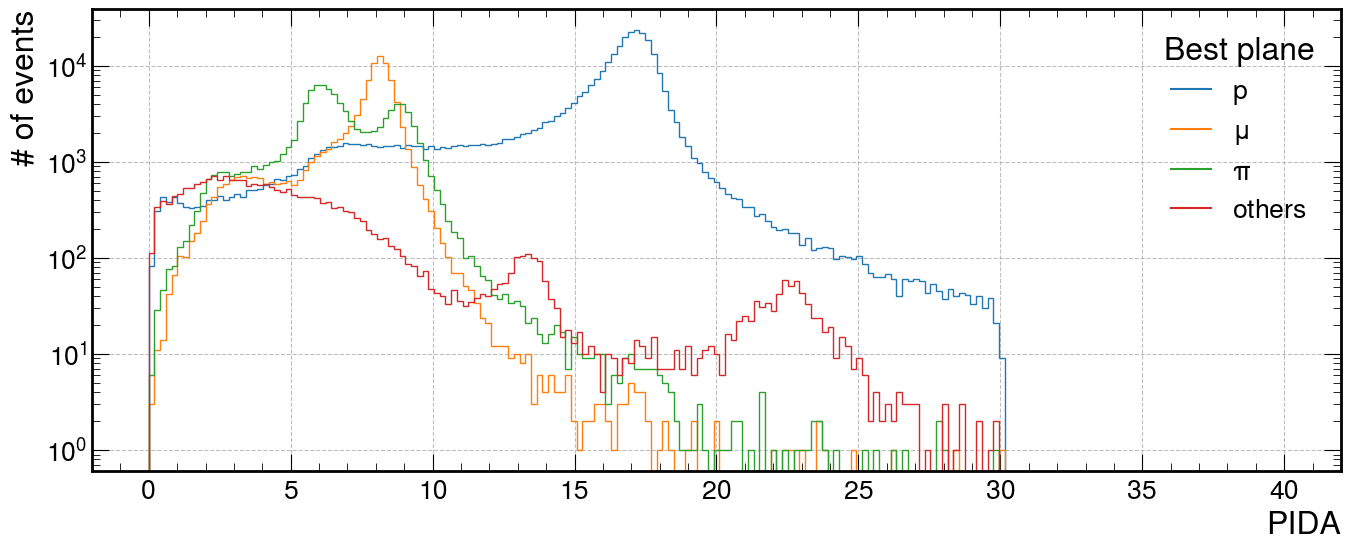

In [777]:

from matplotlib.lines import Line2D

def plot_pid(df:pl.DataFrame,
            plane="B",
            pida = "trkpidpida",
            actual_variable = None,
            pdg=2212,
            binspid = np.linspace(0,40,200),
            notthispdg=False,
            threshold_pnc = 0.85,
            ShowersAndTracks=False,
            onlyShower=False,
            onlycontained=True,
            label="",
            onlyselected=True,
            **kwargs_hist,
            ):
    
    title = f'Plane {plane}'
    if plane=="B":
        # df = getbestof(df, 'trkg4pdg_planes')
        # df = getbestof(df, 'trkpidpida')
        # df = getbestof(df, 'trkpurity_planes')
        # df = getbestof(df, 'trkcompleteness_planes')
        title = 'Best plane'

    if onlyselected and 'selected' in df.columns:
        df = df.filter(
            pl.col('selected')
        )
    trkpdg = f"trkg4pdg_planes_{plane}"
    if (pdg != -1):
        if (notthispdg):
            df = df.filter(pl.col(trkpdg).abs()!=pdg)
        else:
            df = df.filter(pl.col(trkpdg).abs()==pdg)
        particlename = particle.Particle.from_pdgid(pdg).latex_name
        particlename = particlename.strip("^{+}")
        particlename = particlename.strip("^{-}")
    else:
        df = df.filter(
            pl.col(trkpdg).abs()!=2212,
            pl.col(trkpdg).abs()!=211,
            pl.col(trkpdg).abs()!=13,
        )
        particlename='others'
        
    df = df.filter(
        pl.col(f'trkpurity_planes_{plane}') > threshold_pnc,
        pl.col(f'trkcompleteness_planes_{plane}') > threshold_pnc,
        (ShowersAndTracks) | (pl.col('trkPFPIsTrack')),
        (not onlyShower) | ~(pl.col('trkPFPIsTrack')),
        ((not onlycontained) | (pl.col(f'trkIsContained')))
    )
    if notthispdg:
        label = r'not ${{{}}}$'.format(particlename) + label
    else:
        label = r'${{{}}}$'.format(particlename) + label
        
    pida_p = f"{pida}_{plane}"
    if pida_p not in df.columns:
        pida_p = pida

    if actual_variable is not None:
        data = actual_variable(df)
    else:
        data = df[pida_p]
    plt.hist(data, binspid, histtype='step',label=label, **kwargs_hist)
    # Create new legend handles but use the colors from the existing ones
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor(), ls=h.get_linestyle()) for h in handles]
    
    plt.legend(title = title, handles=new_handles, labels=labels)
    return

plt.figure()
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=2212)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=13)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=211)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=-1)
plt.yscale('log')
plt.xlabel('PIDA')
plt.ylabel('# of events')

In [778]:
def ismu():
    return pl.col('trkg4pdg_planes_B').abs()==13
dfall = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B'),
)


minP = 0.8
minC = 0.8
minV=minP*minC
if 'trkg4mother_planes_B' in dfall.columns:
    dfall_enough_pnc = dfall.group_by(selection_events()).agg(
        ((pl.col('trkg4pdg_planes_B').abs() == 13) & (pl.col('trkg4mother_planes_B')==0) & (pl.col('pnc') > minV) & (pl.col('trklen')>0)).any().alias('hasmu')
    )
else:
    dfall_enough_pnc = dfall.group_by(selection_events()).agg(
        ((pl.col('trkg4pdg_planes_B').abs() == 13) & (pl.col('pnc') > minV) & (pl.col('trklen')>0)).any().alias('hasmu')
    )
print(len(dfall_enough_pnc), len(dfall_enough_pnc.filter(~pl.col('hasmu'))), len(dfall_enough_pnc.filter(~pl.col('hasmu')))/len(dfall_enough_pnc))

dfall_enough_pnc = dfall_enough_pnc.filter(
    pl.col('hasmu')
).select(selection_events())

dfall = dfall.join(dfall_enough_pnc, on=selection_events()).sort(selection_events())
dfallmu = dfall.group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)

234571 31490 0.1342450686572509


In [779]:

def plot_purity_completeness(df:pl.DataFrame,
                             dffiltered:pl.DataFrame,
                             dfall:pl.DataFrame,
                             type="purity",
                             binse=None,
                             label=None,
                             plotnevents=False,
                             theselection="selected"
                             ):
    
    if theselection in df.columns:
        df = df.filter(
            pl.col(theselection)
        )
    if not binse:
        binse = np.logspace(-1,2, 100)
    bnall, b = np.histogram(dfall['enu_truth'], bins=binse)
    bn, b = np.histogram(df['enu_truth'], bins=binse)
    bnfiltered, b = np.histogram(dffiltered['enu_truth'], bins=binse)
    # plt.hist(b[:-1], b, weights=bn, histtype='step');

    completeness = np.divide(bn, bnall, out=np.zeros_like(bnall, dtype=np.float64), where=bnall!=0)
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    if type=="completeness":
        val = completeness
    elif type=="purity":
        val = purity
    else:# type=="cnp":
        type = "P x C"
        val = purity*completeness

    plt.hist(b[:-1], b, weights=val, histtype='step', label=label);
    plt.ylabel(type.title())
    plt.xlabel('Neutrino energy [GeV]')
    plt.legend()
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bnall, alpha=0.2, log=False)
        ax2.set_ylabel(rf'# of  events')
        ax2.set_yscale('log')
        ax2.grid(False)
    plt.sca(ax)
    return val, b

def print_ratio(a, b):
    try:
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
    except Exception as error:
        # print(error)
        a=len(a.group_by(selection_events()).agg())
        b=len(b.group_by(selection_events()).agg())
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
def plot_ratio(data, bins, var='enu_truth', general_filter=None, thefilter=None, plotnevents=False):
    if general_filter is not None:
        data = general_filter(data)
    if thefilter is None:
        def thefilter(df):
            return df.filter(ismu())
    data_filtered = thefilter(data)
    bt, b = np.histogram(data[var], bins=bins)
    bm, b = np.histogram(data_filtered[var], bins=bins)
    bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
    # print(sum(bm),sum(bt))
    plt.hist(b[:-1], b, weights=bratio, histtype='step')
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bt, alpha=0.2, log=False)
        # ax2.hist(b[:-1], b, weights=bm, alpha=0.2, log=False)
        ax2.set_ylabel(rf'# of events')
        ax2.grid(False)
    plt.sca(ax)

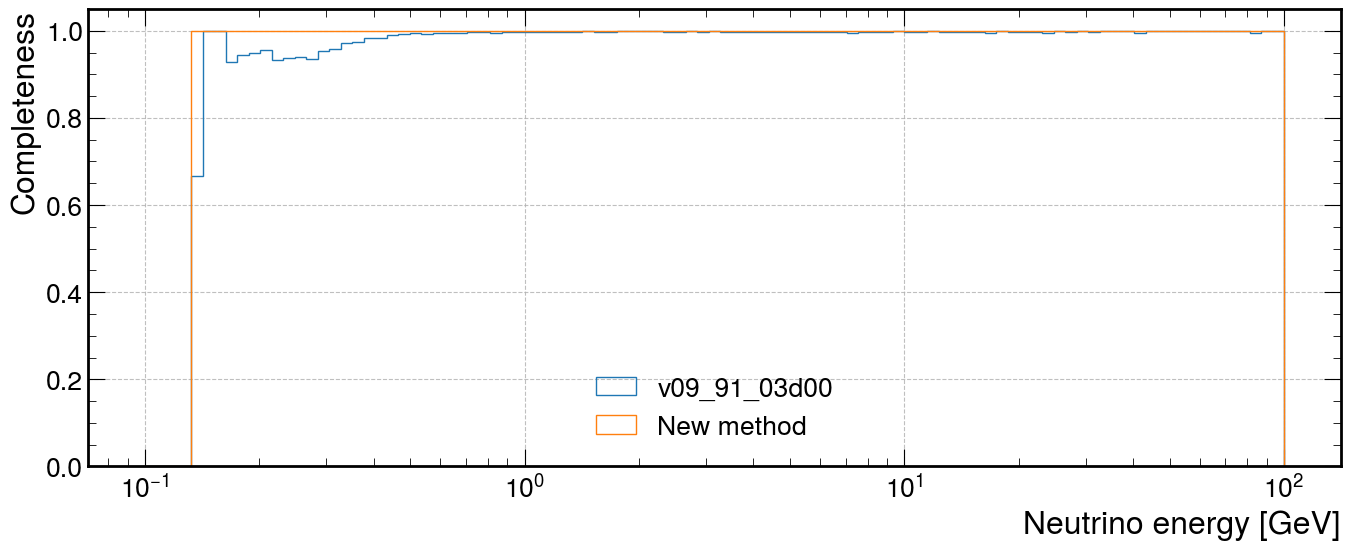

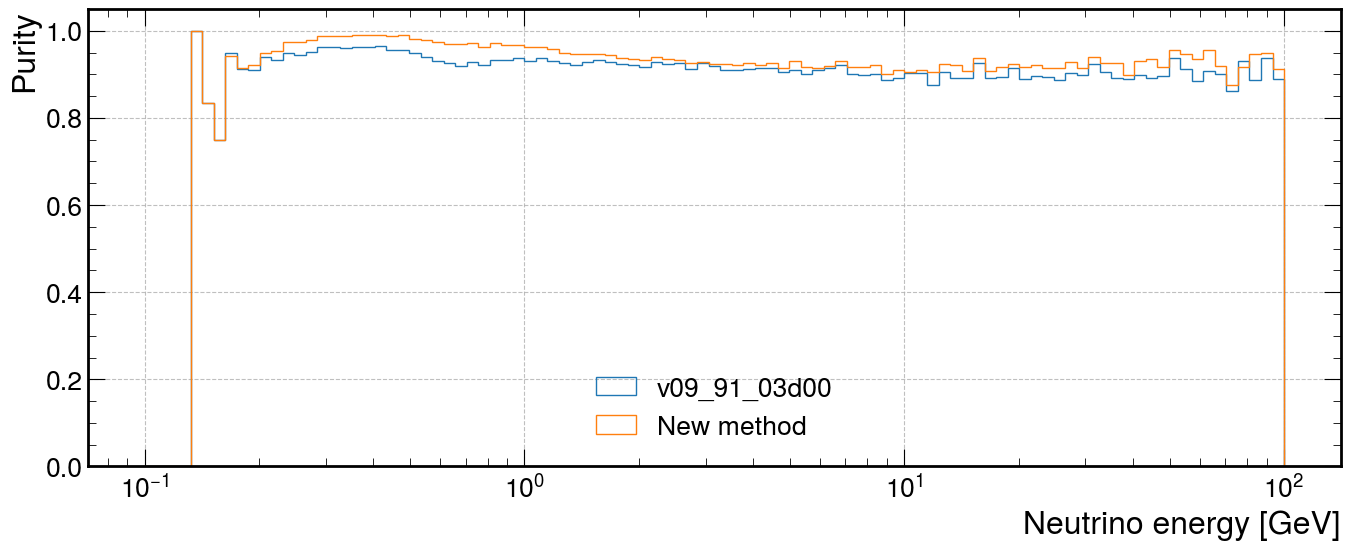

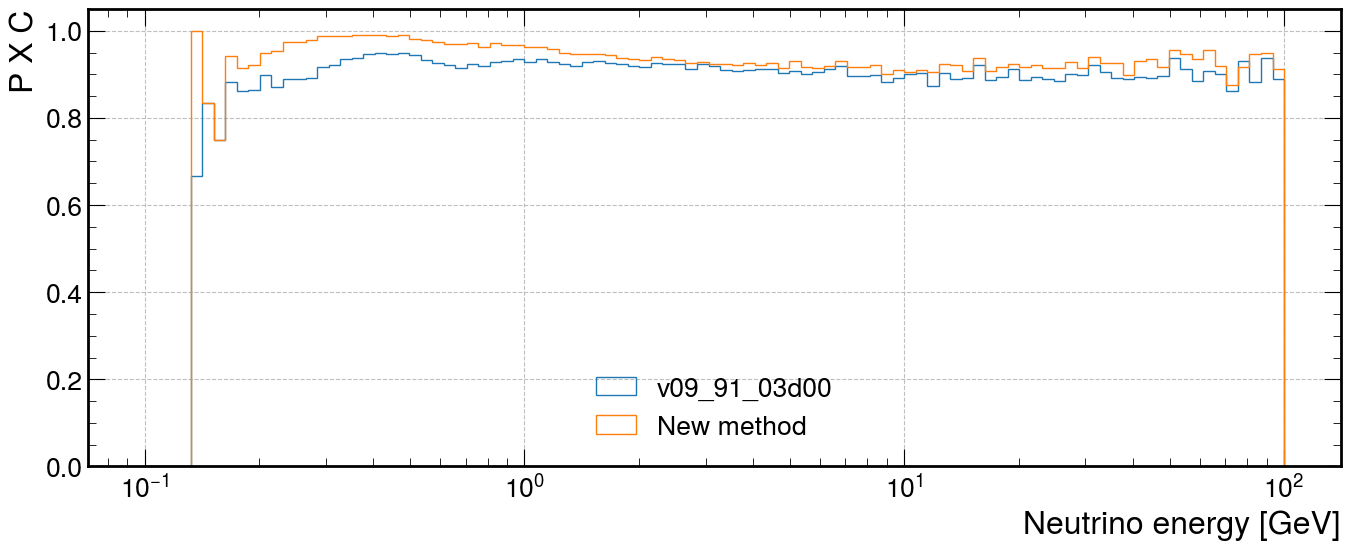

In [780]:
# I tried 1e3 cut, virtually no change...
def create_mucandidates(df):
    dfselected = df.sort('trklen').filter(
        pl.col('trkPFPIsTrack'),
        pl.col('trklen')>0
    ).group_by(selection_events(), maintain_order=True).agg(
        pl.col('trkId').last(),
    ).with_columns(
        pl.lit(True).alias("selected_mu")
    )
    df = df.join(dfselected, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
        pl.col('selected_mu').fill_null(False)
    ).group_by(selection_events(), maintain_order=True).agg(
        pl.len().alias('noptions'),
        pl.all()
    ).explode(
        pl.all().exclude(selection_events('noptions'))
    )
    dfismu = df.filter(
        pl.col('selected_mu'),
        pl.col('trkg4pdg_planes_B').abs() == 13
    )
    return df, dfismu

def get_dist_vtx(df:pl.DataFrame):
    return df.with_columns(
        (1/(
            (pl.col('trkstartx')- pl.col('recovtxx'))**2 + 
            (pl.col('trkstarty')- pl.col('recovtxy'))**2 + 
            (pl.col('trkstartz')- pl.col('recovtxz'))**2 
        ).sqrt()).alias('overdistvtx'),
    )
def get_options(df:pl.DataFrame):
    df = df.drop('noptions')
    df = df.group_by(selection_events(), maintain_order=True).agg(
        pl.len().alias('noptions'),
        pl.all()
    ).explode(
        pl.all().exclude(selection_events('noptions'))
    )
    return df
    
def get_biggest(df:pl.DataFrame,
                tailv:dict={'trklen':1,
                       'trkmomllhd':2,
                       'trkPFPScoreIsTrack':2,
                       'distvtx':2,
                      }
                ):
    listsort = [ k for k in  tailv.keys()]
    listvars = [ f'big_{k}' for k in  tailv.keys()]
    df = df.drop(listvars)
    for var, varsort, tt in zip(listvars, listsort, tailv.values()):
        if varsort not in df.columns:
            continue
        dfsel = df.sort(varsort,).group_by(selection_events(), maintain_order=True).agg(
            pl.col('trkId').tail(tt),
        ).explode(
            'trkId'
        ).with_columns(
            pl.lit(True).alias(var)
        )
        df = df.join(dfsel, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
            pl.col(var).fill_null(False)
        )
    return df
def get_rest(df:pl.DataFrame, restpidcut = 13):
    
    df = get_dist_vtx(df)
    df = get_options(df)
    df = df.filter(~((pl.col('trkpidpida_B')>=restpidcut) & (pl.col('noptions')>1)))
    df = get_options(df)
    firsttails = {
       'trklen': 1,
       'trkmomllhd': 2,
       'trkPFPScoreIsTrack': 2,
       'overdistvtx': 2,
    }
    df = get_biggest(df, firsttails)


    dffirst = df.with_columns(
        pl.when(((pl.col('big_trklen')) & (pl.col('big_trkPFPScoreIsTrack')) )).then(True).otherwise(False).alias('selected_mu')
    ).filter(
        pl.col('selected_mu')
    ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
        pl.col('trkId').last()
    )

    secondtails = {
       'trklen': 1,
       'trkmomllhd': 2,
       'trkPFPScoreIsTrack': 2,
       'overdistvtx': 2,
    }
    df = df.join(dffirst, on=selection_events(), how='anti')

    df = get_biggest(df, secondtails)
    df = get_options(df)

    dfsecond = df.with_columns(
        pl.when(((pl.col('big_trklen')) & pl.col('big_trkPFPScoreIsTrack')  )).then(True).otherwise(False).alias('selected_mu')
    ).filter(
        pl.col('selected_mu')
    ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
        pl.col('trkId').last()
    )

    dfselected = pl.concat([dffirst, dfsecond], how='vertical')
    
    return dfselected

def getfineselection(dforiginal:pl.DataFrame,
                     firstselect={"trklen":1,
                                  "trkmomllhd":3,
                                  "trkPFPScoreIsTrack":3},
                     ):

    df = dforiginal.filter(
        (pl.col('trklen')>10),
    )

    df = get_options(df)
    df = df.filter(
        ~((pl.col('trkmomllhd') > 4) & (pl.col('trklen')<50) & pl.col('noptions')>=2)
    )
    df = get_options(df)
    df = df.filter(
        (pl.col('trkmomllhd')> 2.1*1e-3*pl.col('trklen')+0.005) | (pl.col('noptions')==1),
    )
    df = get_biggest(df,firstselect)
    dfselected = df.with_columns(
        pl.when(((pl.col('big_trklen')) & (pl.col('big_trkmomllhd')) & (pl.col('trkmomllhd')>0) & (pl.col('big_trkPFPScoreIsTrack')))).then(True).otherwise(False).alias('selected_mu')
    ).filter(
        pl.col('selected_mu')
    ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
        pl.all().last()
    )

    dfselected = dfselected.select(selection_events(['trkId']))
    
    return dfselected

def create_mucandidates_2(df:pl.DataFrame,
                          cut=1.7e3,
                          pidacut=13,
                          pidacut_low=10,
                          restpidcut=13,
                          filter_shower=True,
                          calocut=0, # was 3
                          calocutpida=0., # was 0.1
                          calocut_new=1, 
                          fineselection=True,
                          firstselect={"trklen":1,
                                      "trkmomllhd":3,
                                      "trkPFPScoreIsTrack":3},
                          afterfine = True,
                          includeall = True,
                          ):

    # if 'allcalo' not in df.columns:
    #     df = df.group_by(selection_events(), maintain_order=True).agg(
    #         pl.col('trkcalo_planes_B').sum().alias('allcalo'),
    #         pl.all()
    #     ).explode(pl.all().exclude(selection_events('allcalo')))


    calovariable = "allcalo_planes_B"
    dforiginal = df
    df = df.filter(
        pl.col('trklen')>0
    )

    df = get_options(df)
    df = df.filter(
        ~((pl.col('trklen') >= cut) & (pl.col('noptions')>1)),
        # pl.col('trkPFPIsTrack'),
    )
    df = get_options(df)
    df = df.filter(
        ~((pl.col(calovariable) >= calocutpida) & (pl.col('trkpidpida_B') > pidacut) & (pl.col('noptions')>1)),
        # pl.col('trkPFPIsTrack'),
    )
    if filter_shower: 
    #     # Tested: there is only ~4% of tracks tagged as muon here with PxC > 0.36
        df = get_options(df)
        df = df.filter(
        ~((pl.col(calovariable).is_between(0.3,2)) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1))
        )
        df = get_options(df)
        df = df.filter(
        ~((pl.col('trkpidpida_B') < 5) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1))# & (pl.col("allcalo")>2))
        )

    df = get_options(df)
    dfallcontained = df.filter(
        (pl.col(calovariable) >= calocut) & ~(pl.col('trkIsContained')) & (pl.col('noptions')>1)
    ).group_by(selection_events()).agg(
    ).with_columns(
        pl.lit(False).alias('allcontained')
    )
    df = df.join(dfallcontained, on=selection_events(), how='left', coalesce=True).with_columns(
        pl.col('allcontained').fill_null(True)
    )
    df = df.filter(
        ~((pl.col(calovariable) >= calocut_new) & (pl.col('trkIsContained')) & ~(pl.col('allcontained'))),
    )
    df = get_options(df)
    df = df.filter(
        ~((pl.col(calovariable) >= calocut) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>=2)),
        ~((pl.col(calovariable) >= calocut) & ~(pl.col('trkPFPIsTrack')) & (pl.col('trkpidpida_B')>=pidacut_low)),
        ~((pl.col(calovariable) >= calocut) & (pl.col('trkPFPIsTrack')) & (pl.col('noptions')>=2) & (pl.col('trkpidpida_B')>pidacut_low)),
    )
    df = get_options(df)
    # df = df.filter(
    #     ~((pl.col(calovariable) >= calocut) & (pl.col('trkPFPIsTrack')) & (pl.col('noptions')>=2) & (pl.col('trkpidpida_B')>pidacut_low)),
    # )
    df = df.with_columns(
        pl.lit(True).alias('candidate')
    )
    dfcandidates = df
    df = get_options(df)
    if fineselection:
        dfselected = getfineselection(df, firstselect=firstselect) 
    else:
        dfselected = df.sort(
            'trklen',
        ).group_by(selection_events(), maintain_order=True).agg(
            pl.col('trkId').last(),
        )

    if afterfine:
        dfrest = df.join(dfselected, on=selection_events(), how='anti')
        dfrest = dfrest.filter(pl.col('candidate'))
        dfrestselected = get_rest(dfrest, restpidcut=restpidcut)
        dfrestselected = dfrestselected
        dfselected = pl.concat([dfselected, dfrestselected], how='vertical')

    dfrest = dforiginal.join(dfselected, on=selection_events(), how='anti')
    if includeall:
        dfrest = get_options(dfrest)
        dfrest = dfrest.filter(
            ~((pl.col('trklen') >= cut) & (pl.col('noptions')>1)),
        )
        dfrestselected = dfrest.sort('trklen').group_by(selection_events()).agg(
            pl.col('trkId').last()
        )
        dfselected = pl.concat([dfselected, dfrestselected], how='vertical')


    dfselected = dfselected.with_columns(
        pl.lit(True).alias("candidate"),
        pl.lit(True).alias("selected_mu"),
    )
    # dforiginal = df
    dforiginal = dforiginal.join(dfselected, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
        pl.col('candidate').fill_null(False),
        pl.col('selected_mu').fill_null(False),
    )
    dfcandidates = dfcandidates.with_columns(
        change_status=pl.col('candidate')
    ).select(selection_events('trkId','change_status'))
    dforiginal = dforiginal.join(dfcandidates, on=selection_events('trkId'), how='left', coalesce=True)
    dforiginal = dforiginal.with_columns(
        candidate = pl.when(pl.col('change_status')).then(True).otherwise(pl.col('candidate'))
    ).drop('change_status')

    dfismu = dforiginal.filter(
        pl.col('selected_mu'),
        pl.col('trkg4pdg_planes_B').abs() == 13
    )
    return dforiginal, dfismu
dfmuca = []

dfmucamu = []
i =0;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates(dfall)
i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=False, includeall=True, afterfine=True)

labels = [ i for i in range(len(dfmuca))]
if len(labels)==2:
    labels = ['v09_91_03d00', 'New method']
extra=""
plt.figure()
for i, (dfc, dfcmu, label) in enumerate(zip(dfmuca, dfmucamu, labels)):
    plot_purity_completeness(dfc, dfcmu, dfallmu, type='completeness', label=label, theselection='selected_mu')
    plt.xscale('log')
plt.figure()
for i, (dfc, dfcmu, label) in enumerate(zip(dfmuca, dfmucamu, labels)):
    plot_purity_completeness(dfc, dfcmu, dfallmu, type='purity', label=label, theselection='selected_mu')
    plt.xscale('log')
plt.figure()

pncs = []*len(dfmuca)
pncsbins = 0
for i, (dfc, dfcmu, label) in enumerate(zip(dfmuca, dfmucamu, labels)):
    # v, b = plot_purity_completeness(dfc, dfcmu, dfallmu, type='pnc', label=label, plotnevents=(i==1))
    v, b = plot_purity_completeness(dfc, dfcmu, dfallmu, type='pnc', label=label, plotnevents=False, theselection='selected_mu')
    pncs.append(v)
    pncsbins=b
    plt.xscale('log')

In [781]:
# This was done to check that hadron energy was the same as with larsoft
dfmus:pl.DataFrame = dfmuca[0]
dfmus.filter(
    pl.col('run')==74496296,
    pl.col('event').is_between(55100,55200),
    pl.col('selected_mu')
).with_columns(
    trkenrange_mu = (pl.col('trkmomrange_mu')**2 + 0.1057**2).sqrt(),
    trkenllhd = (pl.col('trkmomllhd')**2 + 0.1057**2).sqrt(),
).with_columns(
    haden = (pl.col('allcalo_planes_B') - pl.col('trkcalo_planes_B'))
).select(selection_events('enu_truth', 'trkenllhd', 'trkenrange_mu', 'haden'))

run,subrun,event,enu_truth,trkenllhd,trkenrange_mu,haden
i32,i32,i32,f32,f32,f32,f32
74496296,1,55108,1.216572,0.350698,0.296158,0.639452
74496296,1,55114,0.632541,0.425104,0.297772,0.067301
74496296,1,55115,1.424524,0.895794,0.865525,0.444975
74496296,1,55116,0.722408,0.555475,0.362572,0.081237
74496296,1,55117,4.922468,0.566471,0.596082,0.485587
…,…,…,…,…,…,…
74496296,1,55161,0.233086,1.005571,0.178232,0.01617
74496296,1,55163,85.382889,1.104296,1.153333,8.259459
74496296,1,55165,0.379019,0.58188,0.235412,0.104829


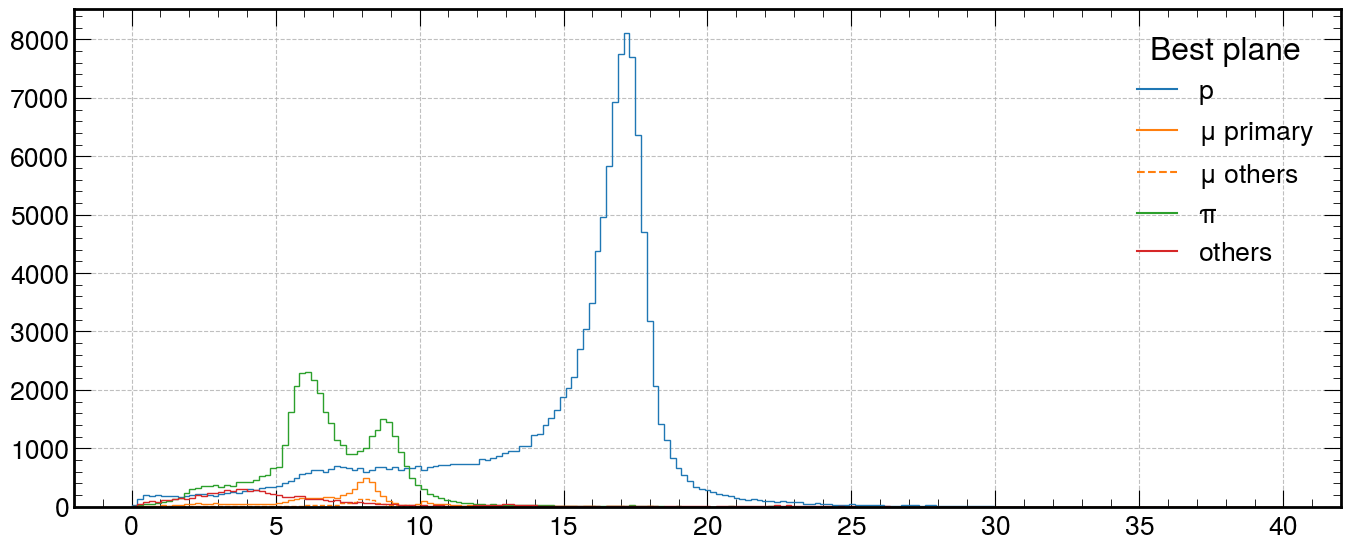

In [782]:
dfmus:pl.DataFrame = dfmuca[1]
dfprpi = dfmus.filter(
    ~pl.col('selected_mu')
)

def onlyprimarymu(df:pl.DataFrame):
    return df.filter(
        pl.col('trkg4mother_planes_B')==0
    )['trkpidpida_B']
def allothermu(df:pl.DataFrame):
    return df.filter(
        pl.col('trkg4mother_planes_B')!=0
    )['trkpidpida_B']
plot_pid(dfprpi, 'B', threshold_pnc=0.7, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=2212)
plot_pid(dfprpi, 'B', threshold_pnc=0.7, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=13, actual_variable=onlyprimarymu, label=' primary')
plot_pid(dfprpi, 'B', threshold_pnc=0.7, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=13, actual_variable=allothermu, label=' others', ls='--', color='C1')
plot_pid(dfprpi, 'B', threshold_pnc=0.7, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=211)
plot_pid(dfprpi, 'B', threshold_pnc=0.7, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=-1)
# plt.yscale('log')

In [783]:
dftest = dfprpi.filter(
    # pl.col('trkPFPIsTrack'),
    # pl.col('trkpidpida_B').is_between(10,15),
    pl.col('trkg4pdg_planes_B').abs()!=2212,
    pl.col('trkg4pdg_planes_B').abs()!=211,
    pl.col('trkg4pdg_planes_B').abs()!=13,
    ).group_by('trkg4pdg_planes_B').agg(
        pl.len()
    ).sort('len').with_columns(
        name=pl.col('trkg4pdg_planes_B').map_elements( lambda x: particle.Particle.from_pdgid(x), return_dtype=pl.Object)
    )
with pl.Config(tbl_rows=35):
    print(dftest)

shape: (39, 3)
┌───────────────────┬────────┬────────┐
│ trkg4pdg_planes_B ┆ len    ┆ name   │
│ ---               ┆ ---    ┆ ---    │
│ i32               ┆ u32    ┆ object │
╞═══════════════════╪════════╪════════╡
│ 1000130290        ┆ 1      ┆ Al29   │
│ 1000130270        ┆ 1      ┆ Al27   │
│ 1000120240        ┆ 1      ┆ Mg24   │
│ 1000150330        ┆ 1      ┆ P33    │
│ 1000010040        ┆ 2      ┆ H4     │
│ 1000140280        ┆ 2      ┆ Si28   │
│ 1000150310        ┆ 2      ┆ P31    │
│ 1000150350        ┆ 2      ┆ P35    │
│ 1000190390        ┆ 2      ┆ K39    │
│ 1000140300        ┆ 3      ┆ Si30   │
│ 1000160320        ┆ 3      ┆ S32    │
│ 1000150320        ┆ 4      ┆ P32    │
│ 1000170350        ┆ 4      ┆ Cl35   │
│ 1000180360        ┆ 4      ┆ Ar36   │
│ 1000160350        ┆ 4      ┆ S35    │
│ 1000160360        ┆ 5      ┆ S36    │
│ 1000160330        ┆ 5      ┆ S33    │
│ 1000020030        ┆ 7      ┆ He3    │
│ …                 ┆ …      ┆ …      │
│ 1000160340        ┆ 12 

In [784]:
def isproton():
    return pl.col('trkg4pdg_planes_B').abs()==2212
def isparticle(pdg):
    return pl.col('trkg4pdg_planes_B').abs()==pdg
def onlyone(n:int=1):
    return pl.col('noptions')==n
def morethan(n:int=2):
    return pl.col('noptions')>=n

def get_all_the_rest(dffull:pl.DataFrame, dfcutted:pl.DataFrame):
    return dffull.join(dfcutted.group_by(selection_events()).agg(), on=selection_events(), how='anti')
def create_proton_candidate(df:pl.DataFrame,
                            cut_pida_easy=10,
                            cut_pida_easy_shower=13,
                            maxmom=1.5,
                            maxcalo=0.8,
                            apply_shower_filter=False,
                            nopt_shower_filter=3,
                            ):
    df = df.filter(
        ~pl.col('selected_mu'),
        pl.col('trklen')>0,
    )

    df = get_options(df)
    df = df.filter(
        ((pl.col('trkpidpida_B')>cut_pida_easy) & (pl.col('trkPFPIsTrack'))) |
        ((pl.col('trkpidpida_B')>cut_pida_easy_shower) & ~(pl.col('trkPFPIsTrack')))
        # | ((onlyone()) & (pl.col('trkpidpida_B')>6) & (pl.col('trkmomrange_pr')<0.6) & (pl.col('trkPFPIsTrack')))
    ).filter(
        pl.col('trkcalo_planes_B')<maxcalo,
        pl.col('trkmomrange_pr').is_between(0,maxmom)
    )
    if apply_shower_filter:
        df = df.filter(
            ~(~(pl.col('trkPFPIsTrack')) & morethan(nopt_shower_filter))
        )
    df = get_options(df)
    df = df.with_columns(
        pl.lit(True).alias('selected_pr')
    )
    return df



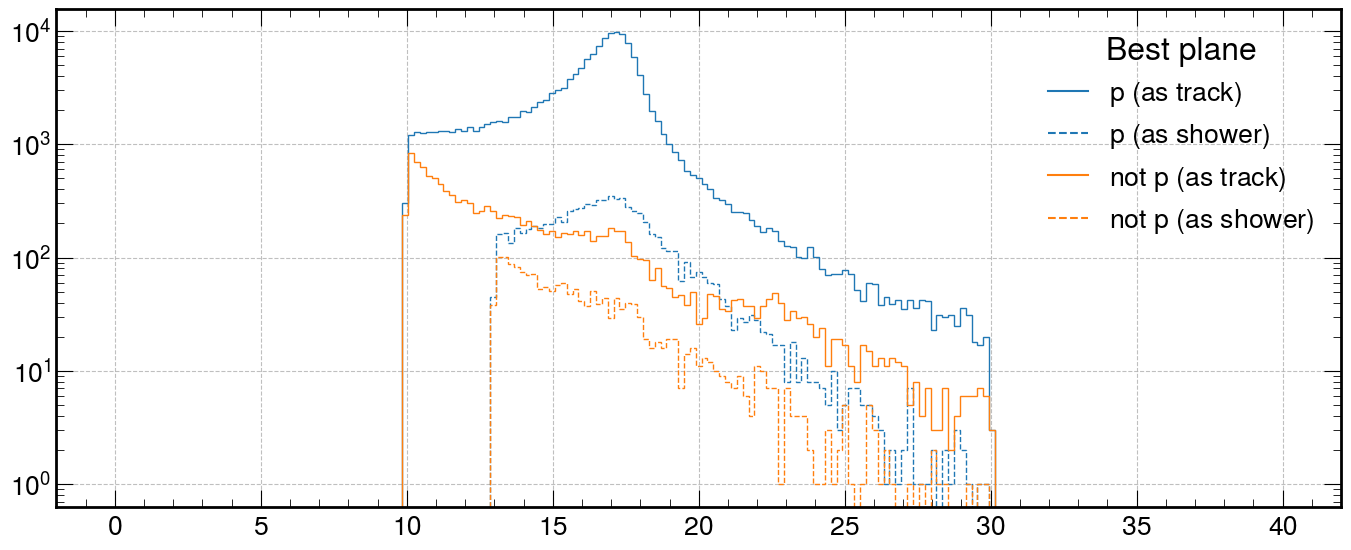

In [785]:
dfprselected = create_proton_candidate(dfmus)
dfprselected = dfmus.join(dfprselected.select(selection_events('trkId', 'selected_pr')), on=selection_events('trkId'), how='left', coalesce=True)
dfprselected = dfprselected.with_columns(
    pl.col('selected_pr').fill_null(False)
)
dftest = dfprselected.filter(pl.col('selected_pr'))
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
plt.yscale('log')

In [786]:

def plot_purity_completeness_particle(df:pl.DataFrame,
                             type="purity",
                             binse=None,
                             label=None,
                             plotnevents=False,
                             minPnC = 0.8,
                             pdg=2212,
                             selection="selected_pr",
                             donotplot=False,
                             ):
    
    # find all existing protons...
    dfallpr = df.filter(isparticle(pdg), pl.col('pnc')>=minPnC)
    # dfallpr_unique = dfallpr.group_by(selection_events('trkg4id_planes_B')).agg(pl.len(), pl.all().last()).filter(pl.col('len')>=2)
    # print(len(dfallpr_unique), len(dfallpr), len(dfallpr_unique)/len(dfallpr))
    if not binse:
        binse = np.logspace(-1,2, 100)
    bnall, b = np.histogram(dfallpr['enu_truth'], bins=binse)
    bn, b = np.histogram(df.filter(pl.col(selection), pl.col('pnc')>=minPnC)['enu_truth'], bins=binse)

    bnfiltered, b = np.histogram(df.filter(pl.col(selection), isparticle(pdg), pl.col('pnc')>=minPnC)['enu_truth'], bins=binse)

    completeness = np.divide(bnfiltered, bnall, out=np.zeros_like(bnall, dtype=np.float64), where=bnall!=0)
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    if type=="completeness":
        type='efficiency'
        val = completeness
    elif type=="purity":
        val = purity
    else:# type=="cnp":
        type = "P x C"
        val = purity*completeness

    if donotplot:
        return val, b
    plt.hist(b[:-1], b, weights=val, histtype='step', label=label);
    plt.ylabel(type.title())
    plt.xlabel('Neutrino energy [GeV]')
    plt.legend()
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bnall, alpha=0.2, log=False)
        ax2.set_ylabel(rf'# of  events')
        ax2.set_yscale('log')
        ax2.grid(False)
    plt.sca(ax)
    return val, b


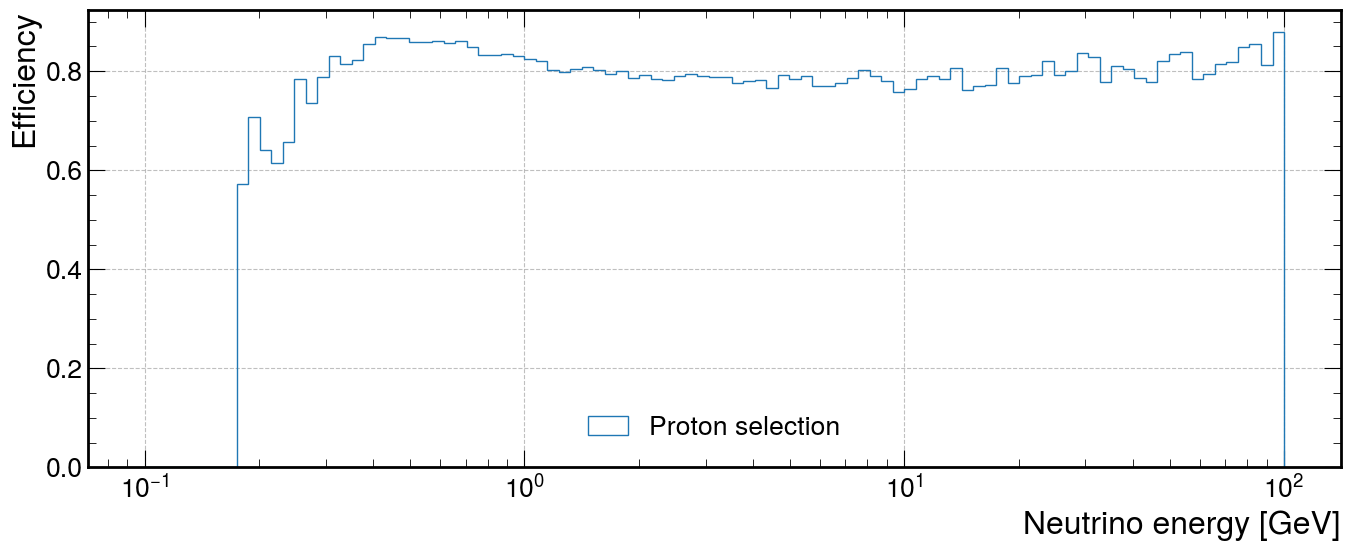

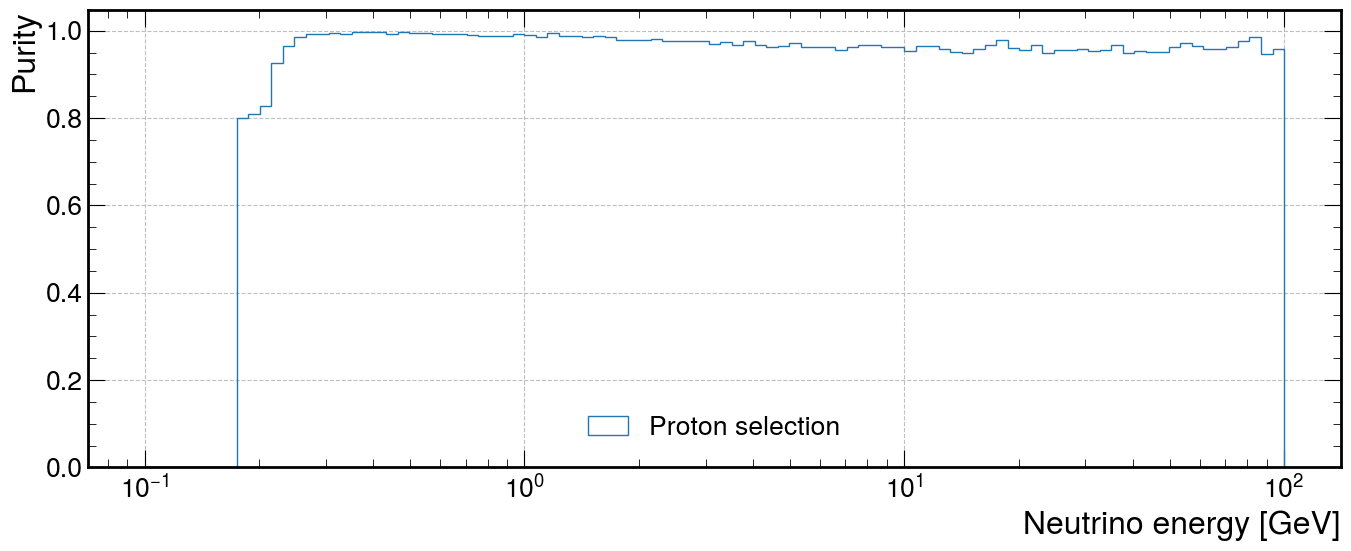

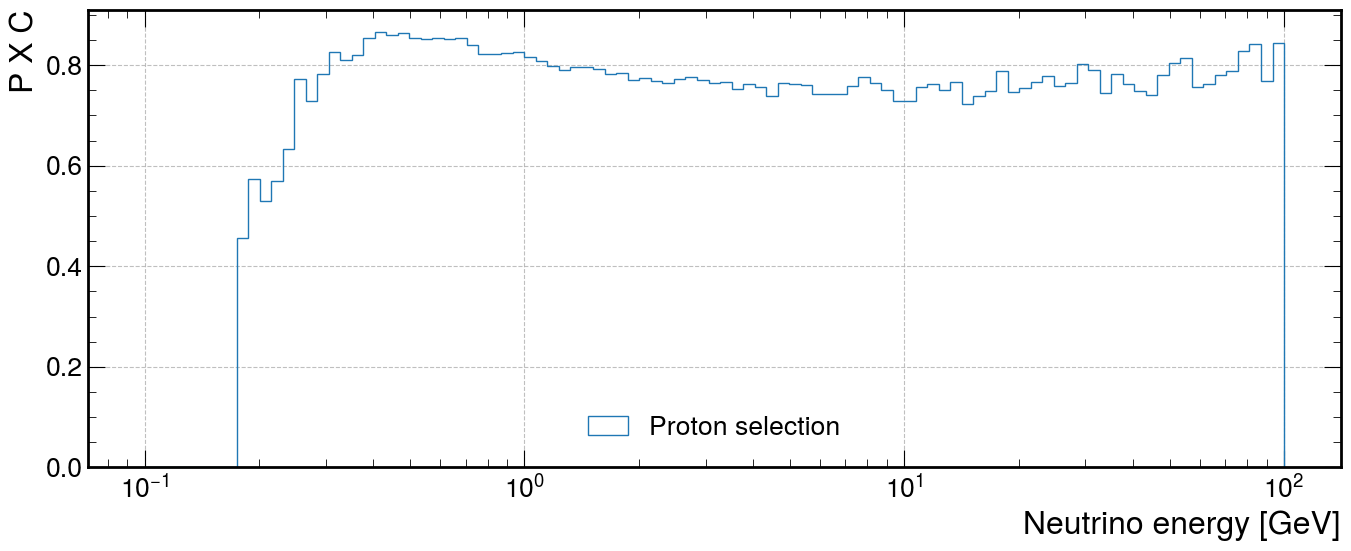

In [787]:
plt.figure()
label='Proton selection'
extra=""
minPnC = 0.81
plot_purity_completeness_particle(dfprselected, type='completeness', label=label, minPnC=minPnC)
plt.xscale('log')
plt.savefig(f'graphs/proton_c{extra}.png', dpi=200)
plt.figure()
plot_purity_completeness_particle(dfprselected, type='purity', label=label, minPnC=minPnC)
plt.xscale('log')
plt.savefig(f'graphs/proton_p{extra}.png', dpi=200)
plt.figure()
v, b = plot_purity_completeness_particle(dfprselected, type='pnc', label=label, plotnevents=False, minPnC=minPnC)
plt.xscale('log')
plt.savefig(f'graphs/proton_pnc{extra}.png', dpi=200)

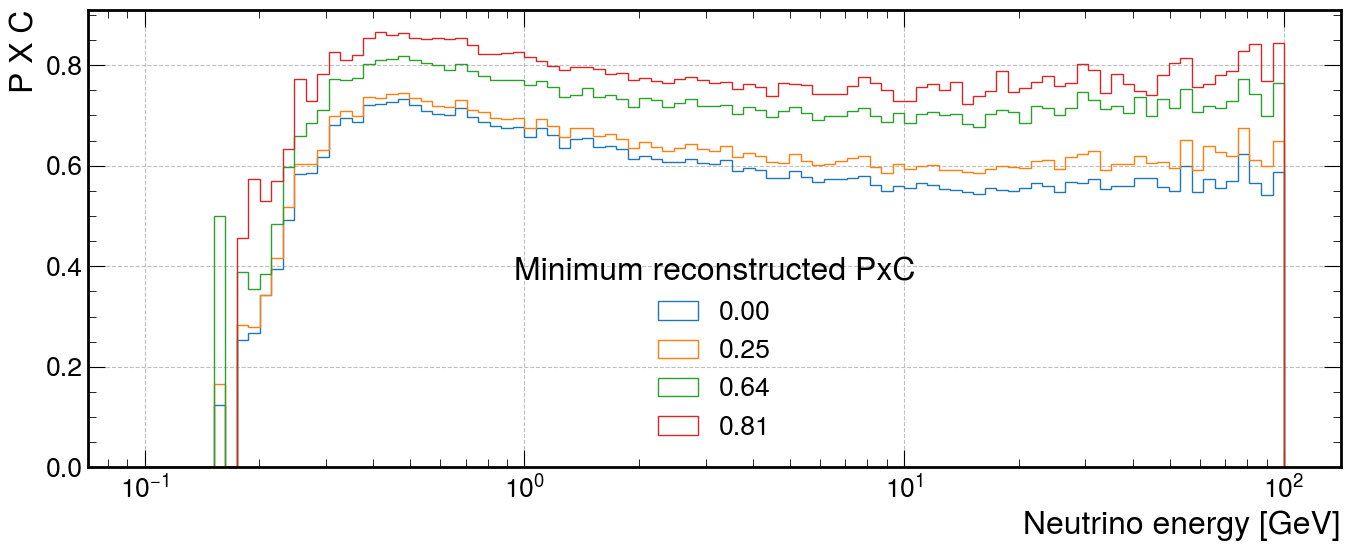

In [788]:
minPNC = [0, 0.5*0.5, 0.8*0.8, 0.9*0.9]
plt.figure()
for minPnC in minPNC:
    v, b = plot_purity_completeness_particle(dfprselected, type='pnc', label=f"{minPnC:.2f}", plotnevents=False, minPnC=minPnC)
plt.xscale('log')
plt.legend(title='Minimum reconstructed PxC')
plt.savefig(f'graphs/proton_pnc_many.png', dpi=200)

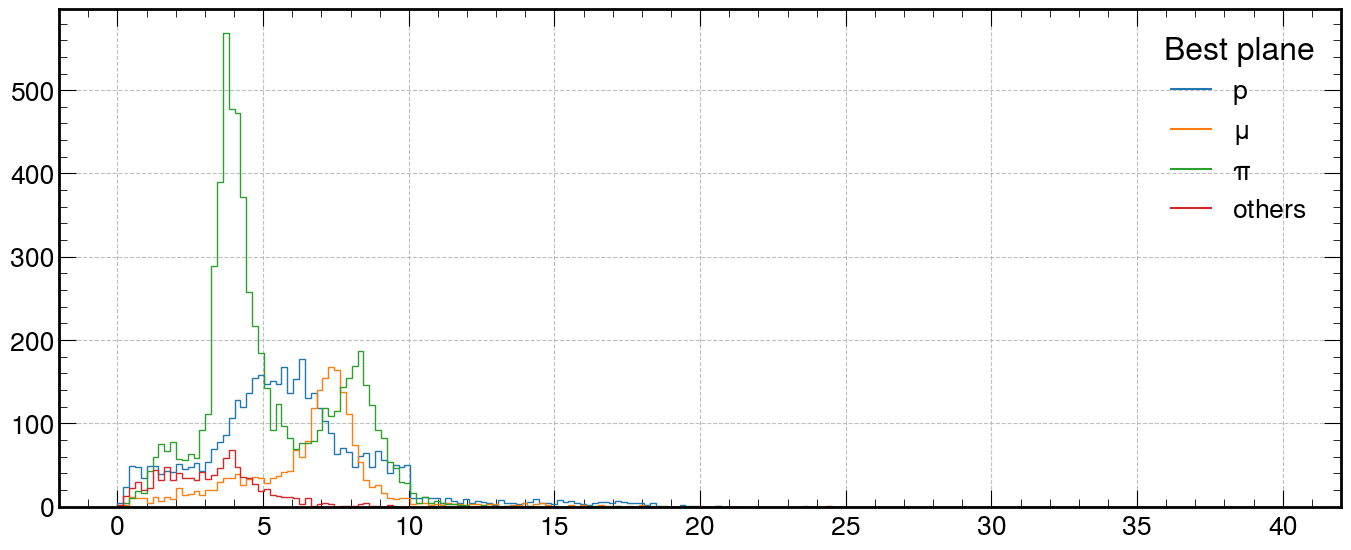

In [789]:
dfpi = dfprselected.filter(
    ~pl.col('selected_mu'),
)
dfpi = get_options(dfpi)
dfpi = dfpi.filter(
    ~pl.col('selected_pr'),
)
def otherpid(df):
    return df['trksmallpida']
plot_pid(dfpi, threshold_pnc=0.95, actual_variable=otherpid, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=2212)
plot_pid(dfpi, threshold_pnc=0.95, actual_variable=otherpid, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=13)
plot_pid(dfpi, threshold_pnc=0.95, actual_variable=otherpid, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=211)
plot_pid(dfpi, threshold_pnc=0.95, actual_variable=otherpid, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=-1)
# plt.yscale('log')

In [790]:
def create_pion_candidate(df:pl.DataFrame,
                          minimum_options_after_remove_mu=2,
                          return_full_efficiency=False,
                          do_not_apply_small_cut_pida=False,
                          do_not_apply_cut_en=False,
                          ):
    df = df.filter(
        pl.col('trklen')>0,
    )
    df = df.filter(
        ~pl.col('selected_mu'),
    )
    df = get_options(df)
    dfwithpr = df.filter(pl.col('selected_pr')).group_by(selection_events()).agg(
        pl.col('selected_pr').count().alias('npr'),
    )
    df = df.join(dfwithpr, on=selection_events(), how='left', coalesce=True)
    df = df.with_columns(
        pl.col('npr').fill_null(0)
    )
    if return_full_efficiency:
        df = df.filter(
            ~pl.col('selected_pr'),
        )
        df = get_options(df)
        df = df.with_columns(
            pl.lit(True).alias('selected_pi')
        )
        return df

    df = df.filter(
        ~pl.col('selected_pr'),
        morethan(minimum_options_after_remove_mu), # Could not find any reliable way if there is muon and no proton
        pl.col('trkPFPIsTrack')
    )

    df = df.filter(
        (do_not_apply_small_cut_pida) | ((pl.col('trksmallpida').is_between(1.,5)) | (pl.col('trksmallpida').is_between(7.5,10))),
        (do_not_apply_cut_en) | (pl.col('trkmomrange_mu').is_between(0.15, 0.5) & pl.col('trkcalo_planes_B').is_between(0.05, 0.5)),
        # pl.col('npr')>=1,
        pl.col('trkIsContained')
    )
    df = get_options(df)
    df = df.with_columns(
        pl.lit(True).alias('selected_pi')
    )

    return df

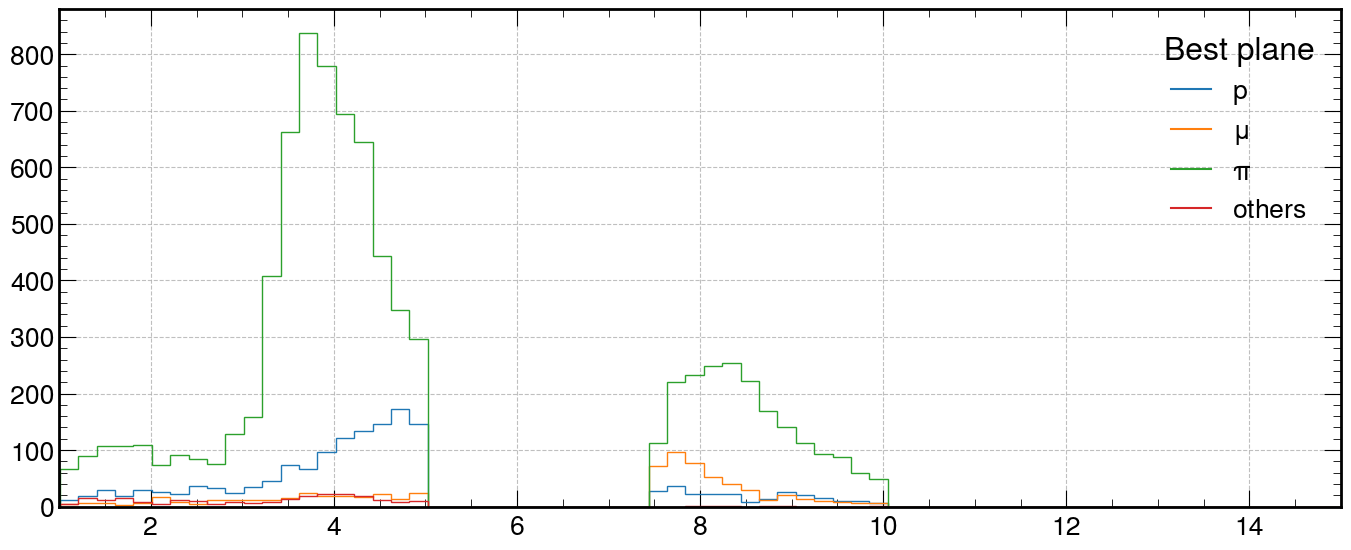

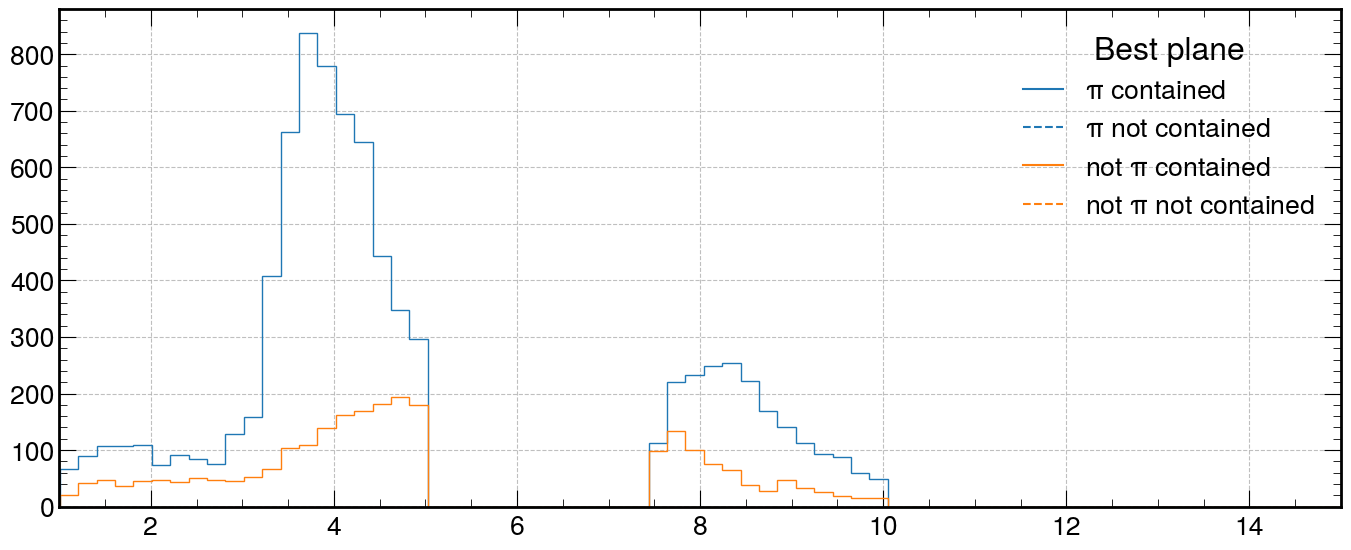

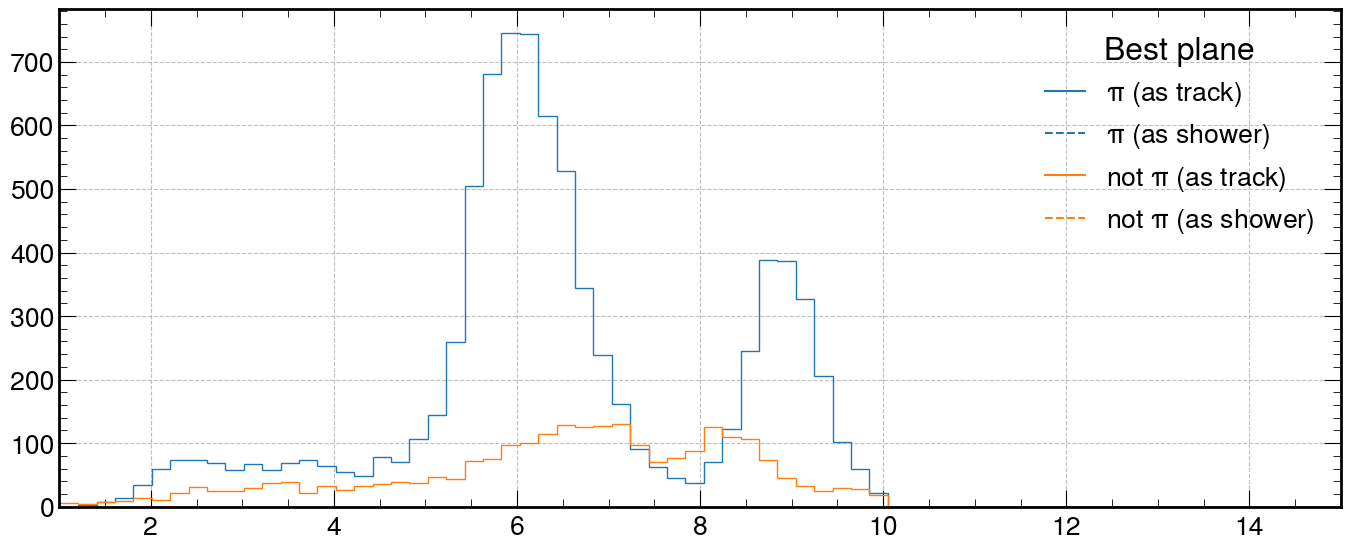

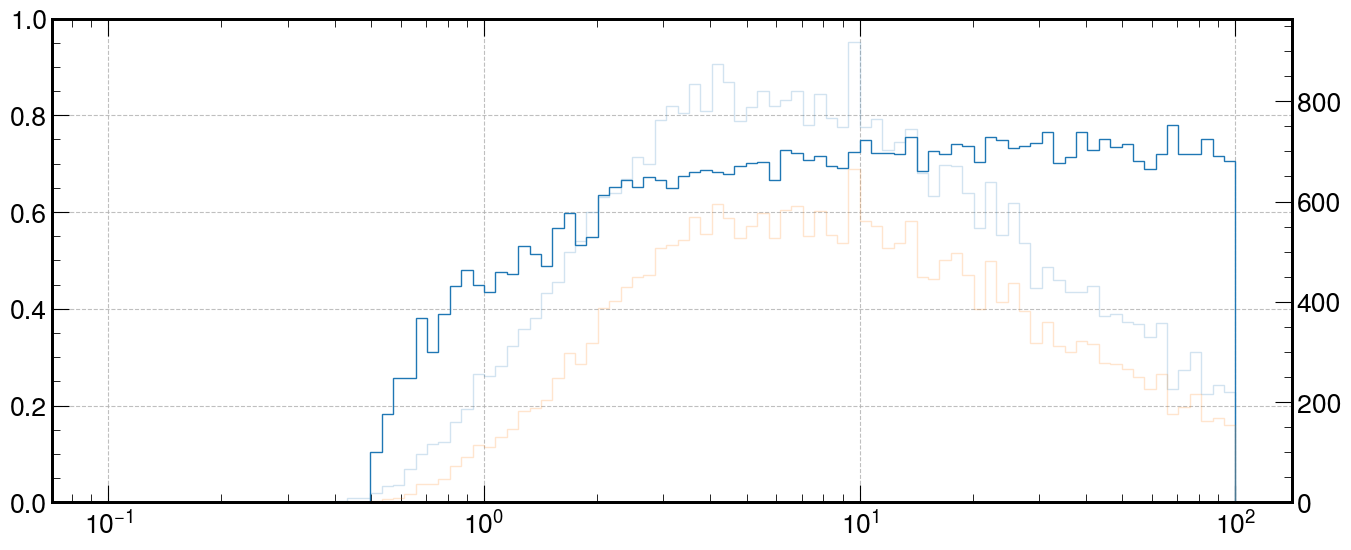

In [791]:
def otherpid(df):
    # return df['trkpidpida_B']
    return df['trksmallpida']
dftest = create_pion_candidate(dfprselected,
                            #    do_not_apply_cut_en=True,
                            #    do_not_apply_small_cut_pida=True,
                               )
pdg=211

minPnC = 0.91
plot_pid(dftest, 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=True, onlyShower=False, onlycontained=True, pdg=2212)
plot_pid(dftest, 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=True, onlyShower=False, onlycontained=True, pdg=13)
plot_pid(dftest, 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=True, onlyShower=False, onlycontained=True, pdg=211)
plot_pid(dftest, 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=True, onlyShower=False, onlycontained=True, pdg=-1)
plt.xlim(1,15)
plt.figure()
plot_pid(dftest, 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=pdg, label=' contained')
plot_pid(dftest.filter(~pl.col('trkIsContained')), 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=pdg, label=' not contained', ls='--', color='C0')
plot_pid(dftest, 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=False, onlyShower=False, onlycontained=True, pdg=pdg, label=' contained', notthispdg=True, color='C1')
plot_pid(dftest.filter(~pl.col('trkIsContained')), 'B', actual_variable=otherpid, threshold_pnc=minPnC, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=pdg, label=' not contained', notthispdg=True, ls="--", color="C1")
plt.xlim(1,15)
plt.figure()
plot_pid(dftest, 'B', threshold_pnc=minPnC, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=pdg, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=minPnC, ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=pdg, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=minPnC, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=pdg, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=minPnC, ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=pdg, label=' (as shower)', notthispdg=True, ls="--", color="C1")
plt.xlim(1,15)
# plt.yscale('log')

# plt.figure()t
# var='enu_truth'
# var='allcalo_planes_B'
# binse = np.logspace(-1,2,100)
# bt, b = np.histogram(dftest.filter(pl.col('pnc')>minPnC, True)[var], bins=binse)
# bm, b = np.histogram(dftest.filter(isparticle(211),pl.col('pnc')>minPnC, pl.col('trkIsContained'))[var], bins=binse)
# # bm, b = np.histogram(dftest.filter(isparticle(211),pl.col('pnc')>minPnC, pl.col('trkPFPIsTrack'))[var], bins=binse)
# # bm, b = np.histogram(dftest.filter(isparticle(211),pl.col('pnc')>minPnC, pl.col('candidate'))[var], bins=binse)
# bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
# plt.hist(b[:-1], b, weights=bratio, histtype='step')
# ax2 = plt.twinx()
# ax2.hist(b[:-1], b, weights=bt, histtype='step', alpha=0.2);
# ax2.grid(False)
# plt.xscale('log')

plt.figure()
var='enu_truth'
# var='allcalo_planes_B'
binse = np.logspace(-1,2,100)
minPnC=0.
bt, b = np.histogram(dftest.filter(pl.col('pnc')>minPnC, True)[var], bins=binse)
bm, b = np.histogram(dftest.filter(pl.col('pnc')>minPnC, isparticle(211))[var], bins=binse)
# bm, b = np.histogram(dftest.filter(isparticle(211),pl.col('pnc')>minPnC, pl.col('trkIsContained'))[var], bins=binse)
# bm, b = np.histogram(dftest.filter(isparticle(211),pl.col('pnc')>minPnC, pl.col('trkPFPIsTrack'))[var], bins=binse)
# bm, b = np.histogram(dftest.filter(isparticle(211),pl.col('pnc')>minPnC, pl.col('candidate'))[var], bins=binse)
bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
plt.hist(b[:-1], b, weights=bratio, histtype='step')
plt.ylim(0,1)
ax2 = plt.twinx()
ax2.hist(b[:-1], b, weights=bt, histtype='step', alpha=0.2);
ax2.hist(b[:-1], b, weights=bm, histtype='step', alpha=0.2);
ax2.grid(False)
plt.xscale('log')
# plt.savefig(f"output2.png")


<Figure size 1400x600 with 0 Axes>

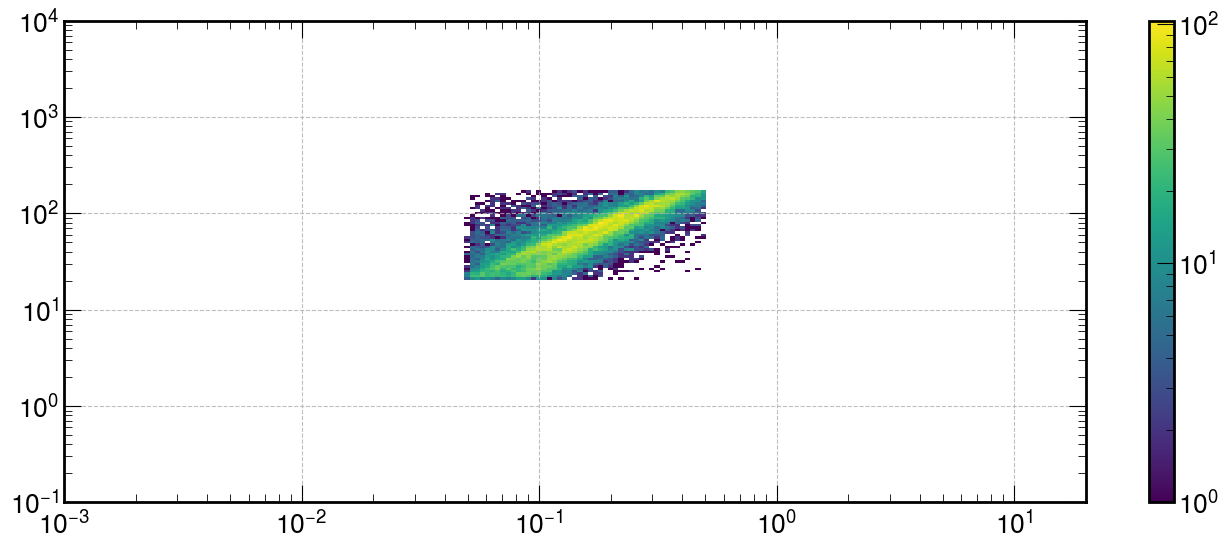

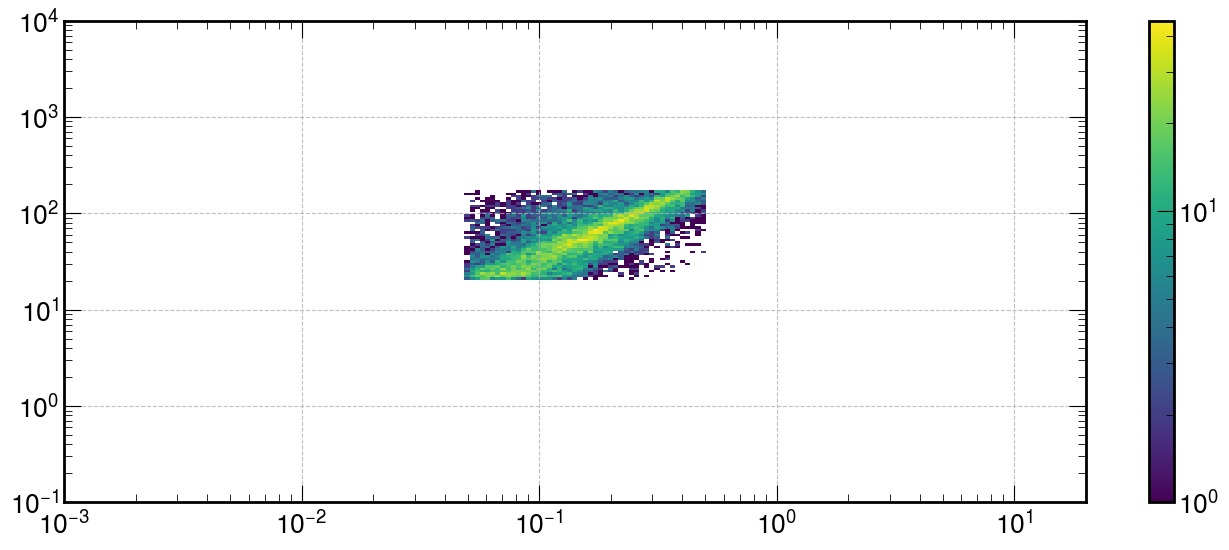

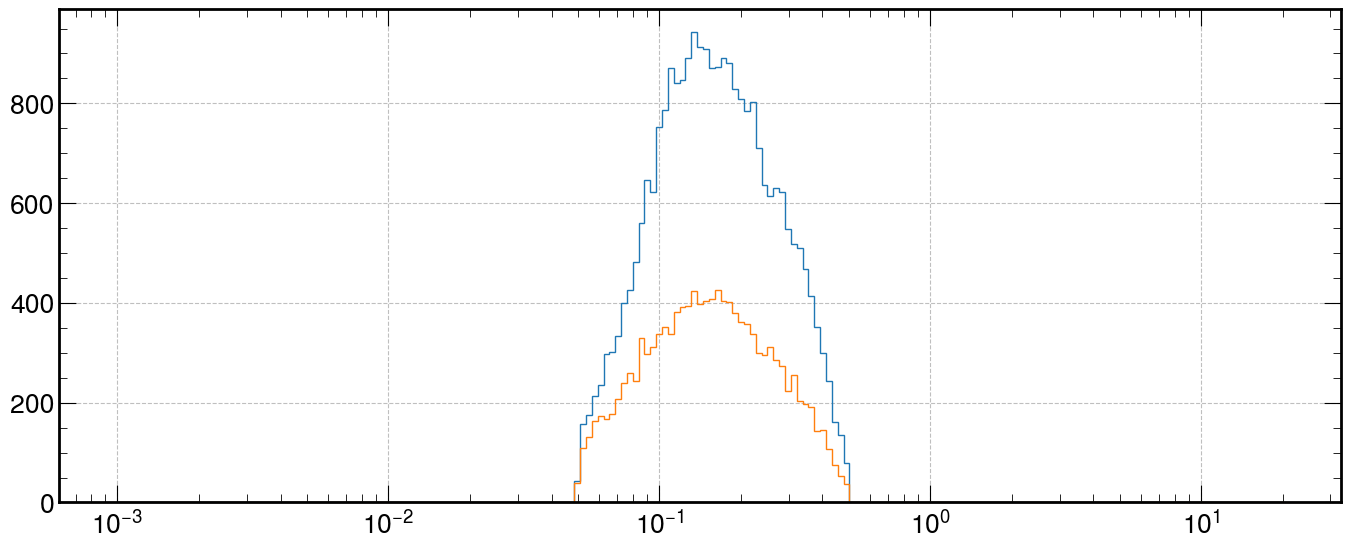

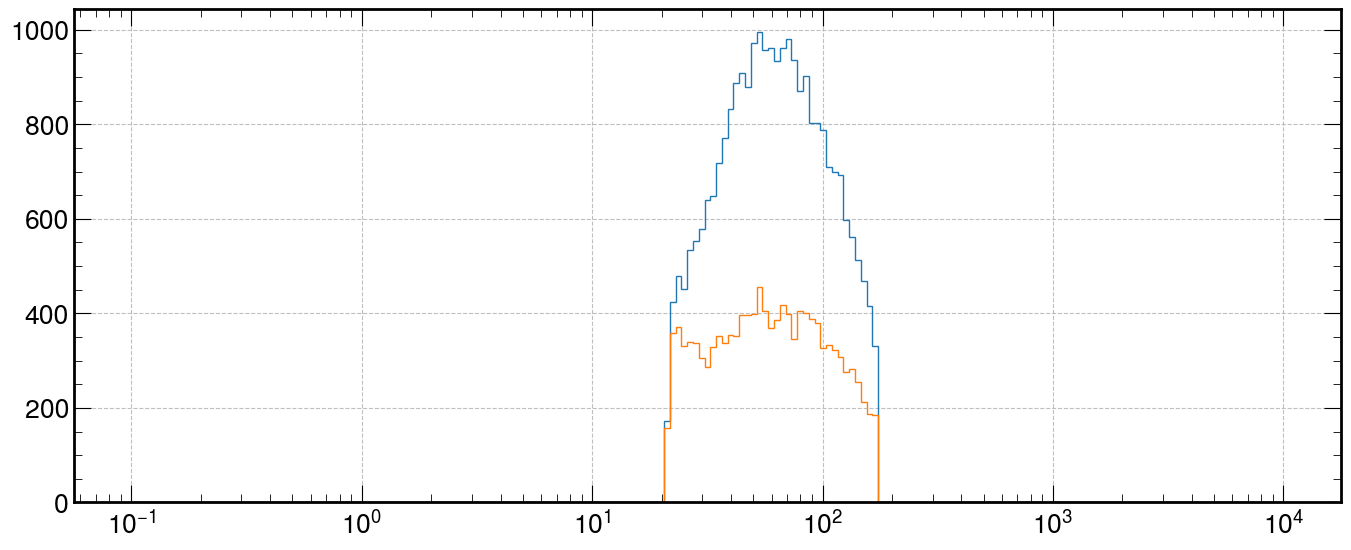

In [792]:
plt.figure()
dftest2 = dftest.filter(
    True,

    # pl.col('pnc')>minPnC,
    # pl.col('trkpidpida_B')>6,
    # pl.col('trkmomrange_mu')>0.07,
    # pl.col('trkcalo_planes_B')<0.7
).with_columns(
    trkg4mom_planes_B = (pl.col('trkg4en_planes_B')**2 - pl.col('trkg4mass_planes_B')**2).sqrt()
)
dftest2 = get_dist_vtx(dftest2)
vy='trklen'
vx='trkcalo_planes_B'
binscalo = np.linspace(-0.1,15,200)
binscalo = np.logspace(-3,np.log10(20), 200)
# binscalo = np.logspace(-2,2,200)
# binsmomrange = np.linspace(0.01, 1, 200)
# binsmomrange = np.logspace(-2, 1.2, 200)
binsmomrange = np.logspace(-1, 4, 200)
# plt.figure()
# plt.scatter(dftest2.filter(isparticle(pdg)) [vx], dftest2.filter(isparticle(pdg))[vy])
# plt.scatter(dftest2.filter(~isparticle(pdg))[vx], dftest2.filter(~isparticle(pdg))[vy], alpha=0.6, s=20, color="C1", facecolor='none')
# plt.ylim(-2,2)
pdg=211

vmax=None
plt.figure()
plt.hist2d(dftest2.filter(isparticle(pdg)) [vx], dftest2.filter(isparticle(pdg))[vy], bins=[binscalo, binsmomrange], cmin=1, norm='log', vmax=vmax);
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.figure()
plt.hist2d(dftest2.filter(~isparticle(pdg)) [vx], dftest2.filter(~isparticle(pdg))[vy], bins=[binscalo, binsmomrange], cmin=1, norm='log', vmax=vmax);
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

plt.figure()
plt.hist(dftest2.filter(isparticle(pdg)) [vx], bins=binscalo, histtype='step')
plt.hist(dftest2.filter(~isparticle(pdg))[vx], bins=binscalo, histtype='step')
plt.xscale('log')
# plt.yscale('log')
plt.figure()
plt.hist(dftest2.filter(isparticle(pdg)) [vy], bins=binsmomrange, histtype='step')
plt.hist(dftest2.filter(~isparticle(pdg))[vy], bins=binsmomrange, histtype='step')
plt.xscale('log')
# plt.yscale('log')

In [793]:
dfnotpi = dftest2.filter(
    True,
    ~isparticle(211),
    pl.col('trksmallpida')<5
).group_by('trkg4pdg_planes_B').agg(
    pl.len()
).sort('len').with_columns(
    name=pl.col('trkg4pdg_planes_B').map_elements( lambda x: particle.Particle.from_pdgid(x), return_dtype=pl.Object)
)
with pl.Config(tbl_rows=35):
    print(dfnotpi)
dfnotpi = dftest.filter(
    isparticle(2212)
).select(selection_events())

dfprpi.join(dfnotpi, on=selection_events(), how='inner')

shape: (12, 3)
┌───────────────────┬──────┬────────┐
│ trkg4pdg_planes_B ┆ len  ┆ name   │
│ ---               ┆ ---  ┆ ---    │
│ i32               ┆ u32  ┆ object │
╞═══════════════════╪══════╪════════╡
│ 3222              ┆ 1    ┆ Sigma+ │
│ -2212             ┆ 3    ┆ p~     │
│ 1000010020        ┆ 8    ┆ D2     │
│ -1                ┆ 8    ┆ d~     │
│ 11                ┆ 23   ┆ e-     │
│ -321              ┆ 89   ┆ K-     │
│ -11               ┆ 117  ┆ e+     │
│ 321               ┆ 266  ┆ K+     │
│ -13               ┆ 1046 ┆ mu+    │
│ 22                ┆ 1930 ┆ gamma  │
│ 13                ┆ 2041 ┆ mu-    │
│ 2212              ┆ 4448 ┆ p      │
└───────────────────┴──────┴────────┘


run,subrun,event,nuPDG_truth,ccnc_truth,mode_truth,nuWeight_truth,enu_truth,vtxx_truth,vtxy_truth,vtxz_truth,recovtxx,recovtxy,recovtxz,lepen,lepmass,leppdg,lepid,ntracks,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4mother,trknhits,trkg4id_planes_U,trkg4id_planes_V,trkg4id_planes_W,…,trkpidndf_U,trkpidndf_V,trkpidndf_W,trkpidpida_U,trkpidpida_V,trkpidpida_W,allcalo_planes_U,allcalo_planes_V,allcalo_planes_W,nallhits_planes_U,nallhits_planes_V,nallhits_planes_W,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4mother_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trktotalen_planes_B,trkpartialen_planes_B,trkpidchi2ndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidndf_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B,trksmallpida,pnc,candidate,selected_mu
i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,i32,i32,i32,i32,i32,…,i32,i32,i32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,f32,f32,i32,f32,f32,i32,i32,f32,f32,f32,i32,f32,f32,f32,f32,i32,f32,f32,i32,f32,f32,bool,bool
1453,1,87,14,0,1,6.3906848e7,2.403838,6.01448,527.757629,1306.274414,6.066012,527.889648,1306.057983,1.011186,0.105658,13,4,7,4,-11.369381,513.426697,1360.999512,-11.389015,499.917145,1356.053467,0.918919,0.082524,1,13,1.011186,0.105658,0,37,-1,1,1,…,-1,14,15,-1.0,1.728586,3.115203,0.682204,0.632122,0.782668,268,314,300,1,13,1.011186,0.105658,0,0.842105,0.101266,19,16,0.025432,22.800468,20.607885,15,278.975861,186.429932,45.020561,34.533493,15,3.115203,0.632122,314,3.341735,0.085276,false,false
1453,1,87,14,0,1,6.3906848e7,2.403838,6.01448,527.757629,1306.274414,6.066012,527.889648,1306.057983,1.011186,0.105658,13,4,7,3,6.452958,528.952881,1305.162109,4.518134,518.97522,1299.869751,1.0,0.52,4,211,0.280997,0.13957,0,39,-1,4,4,…,-1,20,11,-1.0,4.117246,3.749188,0.682204,0.632122,0.782668,268,314,300,4,211,0.280997,0.13957,0,1.0,0.827586,24,24,0.029995,25.604256,22.711067,20,209.799698,105.882736,16.715313,10.832382,20,4.117246,0.632122,314,4.084984,0.827586,true,false
1453,1,87,14,0,1,6.3906848e7,2.403838,6.01448,527.757629,1306.274414,6.066012,527.889648,1306.057983,1.011186,0.105658,13,4,7,6,5.684492,529.944275,1306.478638,4.639579,525.408264,1310.046021,0.653846,0.041262,1,13,1.011186,0.105658,0,26,4,1,1,…,-1,4,6,-1.0,0.62855,3.528903,0.682204,0.632122,0.782668,268,314,300,1,13,1.011186,0.105658,0,0.846154,0.071429,13,11,0.019584,11.883204,11.883204,6,247.621872,126.114616,38.985203,26.426268,6,3.528903,0.632122,300,3.528903,0.06044,true,false
1453,1,87,14,0,1,6.3906848e7,2.403838,6.01448,527.757629,1306.274414,6.066012,527.889648,1306.057983,1.011186,0.105658,13,4,7,2,-13.641445,501.832489,1275.150391,-10.137921,492.928864,1286.900635,0.757282,0.886364,25,-11,0.050653,0.000511,22,103,25,25,25,…,14,33,26,3.805805,6.068652,5.755715,0.682204,0.632122,0.782668,268,314,300,25,-11,0.050653,0.000511,22,0.653846,0.894737,52,34,0.124437,181.569016,168.905075,33,185.286636,84.602547,12.701714,8.441512,33,6.068652,0.632122,314,5.788829,0.58502,false,false
1453,1,87,14,0,1,6.3906848e7,2.403838,6.01448,527.757629,1306.274414,6.066012,527.889648,1306.057983,1.011186,0.105658,13,4,7,5,-4.066885,502.566071,1290.409668,-9.663044,494.567383,1286.654541,0.961538,0.333333,4,211,0.280997,0.13957,0,26,4,-1,4,…,15,-1,6,7.07184,-1.0,6.096251,0.682204,0.632122,0.782668,268,314,300,4,211,0.280997,0.13957,0,1.0,0.818182,18,18,0.0,39.814674,38.090977,15,114.836693,43.38089,1.593946,0.988346,15,7.07184,0.632122,268,7.199201,0.818182,true,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
74517882,1,27267,14,0,1,4.4152072e7,9.067304,-97.575073,-438.834351,576.704468,-97.521797,-438.733368,576.468323,5.874647,0.105658,13

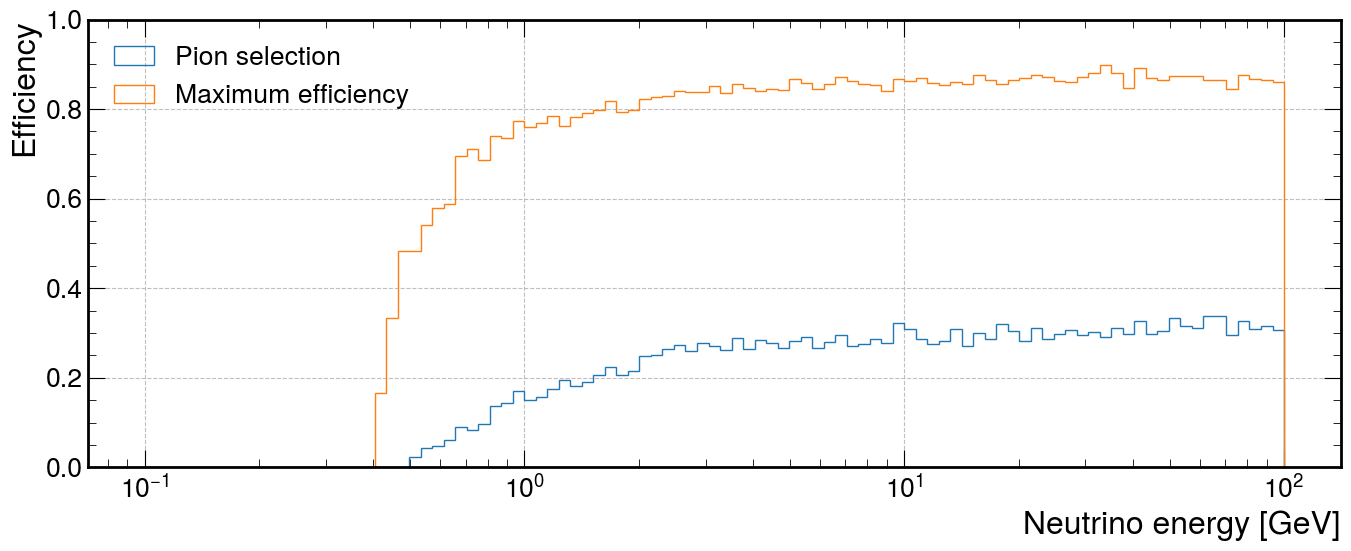

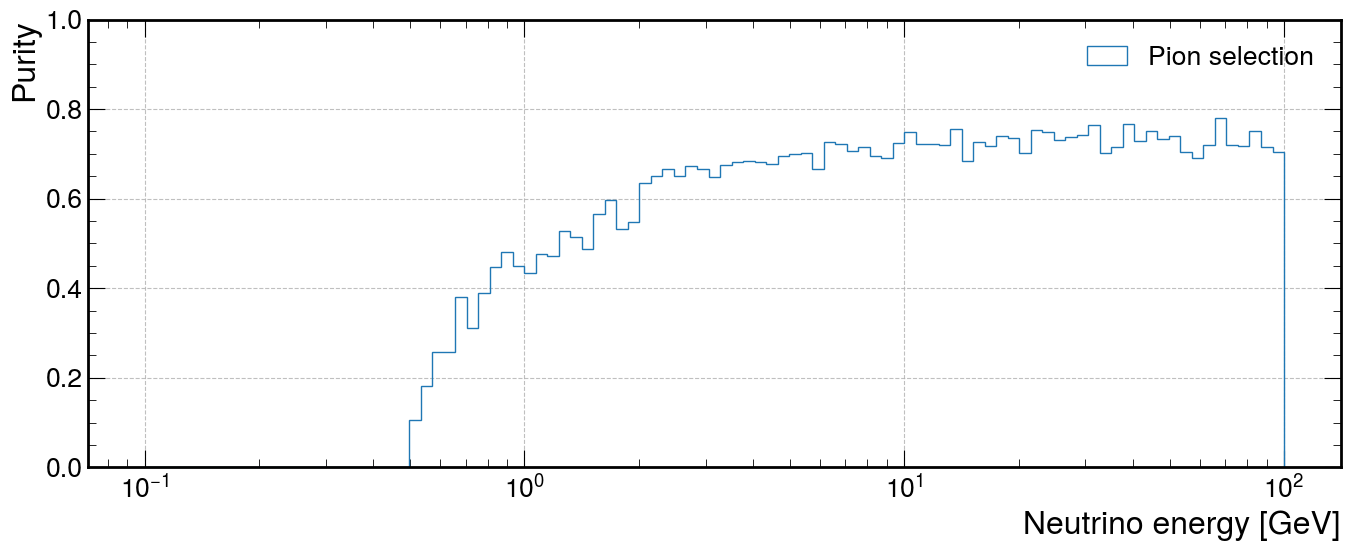

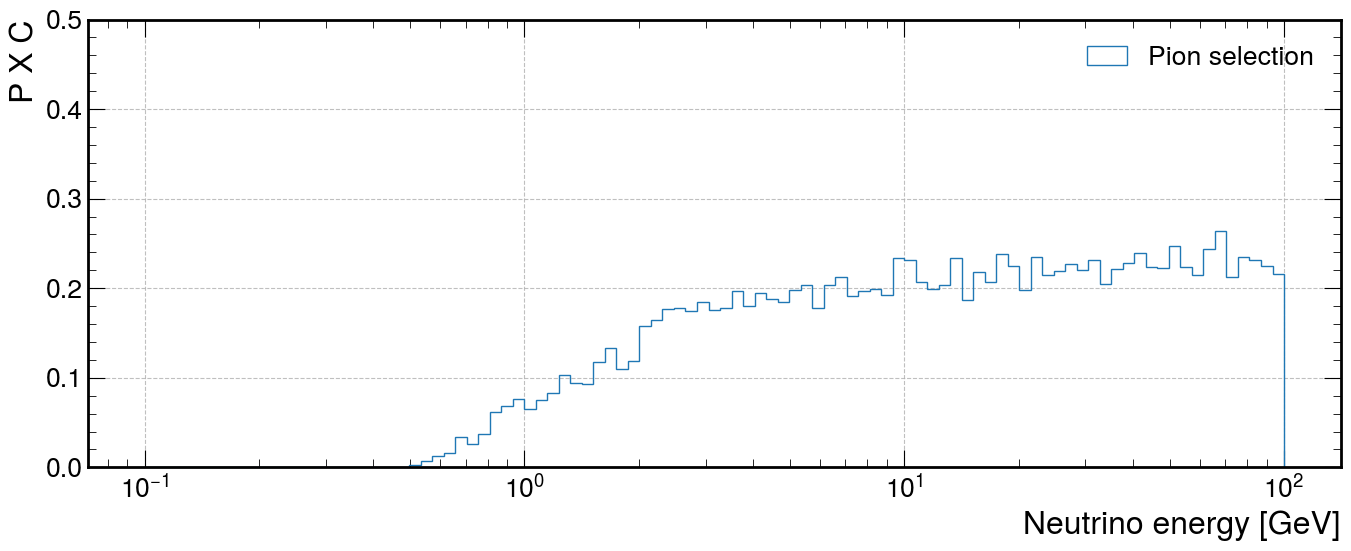

In [794]:
# dfprselected = create_proton_candidate(dfmus)
dfprpiselected = create_pion_candidate(dfprselected,
                                       minimum_options_after_remove_mu=2,
                                    #    do_not_apply_cut_en=True,
                                    #    do_not_apply_small_cut_pida=True,
                                       )
dfprpiselected = dfprselected.join(dfprpiselected.select(selection_events('trkId', 'selected_pi')), on=selection_events('trkId'), how='left', coalesce=True)
dfprpiselected = dfprpiselected.with_columns(
    pl.col('selected_pi').fill_null(False)
)
dfwithpr = dfprpiselected.filter(pl.col('selected_pr')).group_by(selection_events()).agg(
    pl.col('selected_pr').count().alias('npr'),
)
dfprpiselected = dfprpiselected.join(dfwithpr, on=selection_events(), how='left', coalesce=True)
dfprpiselected = dfprpiselected.with_columns(
    pl.col('npr').fill_null(0)
)
dfwithpr = dfprpiselected.filter(pl.col('selected_pi')).group_by(selection_events()).agg(
    pl.col('selected_pi').count().alias('npi'),
)
dfprpiselected = dfprpiselected.join(dfwithpr, on=selection_events(), how='left', coalesce=True)
dfprpiselected = dfprpiselected.with_columns(
    pl.col('npi').fill_null(0)
)
dfmaxeffpi = create_pion_candidate(dfprselected, return_full_efficiency=True)
dfmaxeffpi = dfprselected.join(dfmaxeffpi.select(selection_events('trkId', 'selected_pi')), on=selection_events('trkId'), how='left', coalesce=True)
dfmaxeffpi = dfmaxeffpi.with_columns(
    pl.col('selected_pi').fill_null(False)
)
plt.figure()
label='Pion selection'
extra=""
minPnC = 0.
pdg=211
# dfprpiselected = dfprpiselected.filter(
#     (isparticle(211)) & (pl.col('trkIsContained'))
# )
plot_purity_completeness_particle(dfprpiselected, type='completeness', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi")
val, b = plot_purity_completeness_particle(dfmaxeffpi, type='completeness', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi", donotplot=True)
plt.hist(b[:-1], b, weights=val, histtype='step', label='Maximum efficiency');
plt.ylim(0,1)
plt.legend()
plt.xscale('log')
plt.savefig(f'graphs/pion_c{extra}.png', dpi=200)
plt.figure()
plot_purity_completeness_particle(dfprpiselected, type='purity', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi")
plt.xscale('log')
plt.ylim(0,1)
plt.savefig(f'graphs/pion_p{extra}.png', dpi=200)
plt.figure()
v, b = plot_purity_completeness_particle(dfprpiselected, type='pnc', label=label, plotnevents=False, minPnC=minPnC, pdg=pdg, selection="selected_pi")
plt.xscale('log')
plt.ylim(0,0.5)
plt.savefig(f'graphs/pion_pnc{extra}.png', dpi=200)

In [ ]:
# HERE... this was my attempt, same result in the end...

In [270]:
def isproton():
    return pl.col('trkg4pdg_planes_B').abs()==2212
def onlyone(n:int=1):
    return pl.col('noptions')==n
def morethan(n:int=2):
    return pl.col('noptions')>=n

def get_all_the_rest(dffull:pl.DataFrame, dfcutted:pl.DataFrame):
    return dffull.join(dfcutted.group_by(selection_events()).agg(), on=selection_events(), how='anti')
def create_proton_candidate(df:pl.DataFrame,
                            cut_pida_easy=10,
                            cut_pida_easy_shower=13,
                            return_easy=False,
                            return_second=False,
                            return_last=False,
                            return_concat=False,
                            ):
    df = df.filter(
        ~pl.col('selected_mu'),
        pl.col('trklen')>0,
    )
    dforiginal = df
    
    dfeasy = get_options(df)
    dfeasy = dfeasy.filter(
        onlyone()
    )
    dfeasy_selected = dfeasy.filter(
        ((pl.col('trkpidpida_B')>cut_pida_easy) & (pl.col('trkPFPIsTrack'))) |
        ((pl.col('trkpidpida_B')>cut_pida_easy_shower) & ~(pl.col('trkPFPIsTrack'))) 
    ).filter(
        pl.col('trkcalo_planes_B')<0.8,
        pl.col('trkmomrange_pr').is_between(0,1.5),
         
    )
    if return_easy:
        return dfeasy_selected

    df = get_all_the_rest(dforiginal, dfeasy)
    dfeasy = get_options(df)
    
    dfeasy = dfeasy.filter(
        onlyone(2)
    )
    dfeasy_selected_second = dfeasy.filter(
        ((pl.col('trkpidpida_B')>cut_pida_easy) & (pl.col('trkPFPIsTrack'))) |
        ((pl.col('trkpidpida_B')>cut_pida_easy_shower) & ~(pl.col('trkPFPIsTrack'))) 
    ).filter(
        pl.col('trkcalo_planes_B')<0.8,
        pl.col('trkmomrange_pr').is_between(0,1.5)
    )
    dfeasy_selected_second = get_options(dfeasy_selected_second)
    if return_second:
        return dfeasy_selected_second

    # repeating because it is easier
    dfeasy = get_options(dforiginal)
    dfeasy = dfeasy.filter(
        pl.col('noptions')<=2
    )
    df = get_all_the_rest(dforiginal, dfeasy)
    dfeasy = get_options(df)
    dfeasy_selected_last = dfeasy.filter(
        ((pl.col('trkpidpida_B')>cut_pida_easy) & (pl.col('trkPFPIsTrack'))) |
        ((pl.col('trkpidpida_B')>cut_pida_easy_shower) & ~(pl.col('trkPFPIsTrack'))) 
    ).filter(
        pl.col('trkcalo_planes_B')<0.8,
        pl.col('trkmomrange_pr').is_between(0,1.5)
    )
    dfeasy_selected_last = get_options(dfeasy_selected_last)
    if return_last:
        return dfeasy_selected_last
    dfallselec = pl.concat([dfeasy_selected, dfeasy_selected_second, dfeasy_selected_last], how='vertical')
    if return_concat:
        return get_options(dfallselec)

    df = dforiginal.filter(
        ((pl.col('trkpidpida_B')>cut_pida_easy) & (pl.col('trkPFPIsTrack'))) |
        ((pl.col('trkpidpida_B')>cut_pida_easy_shower) & ~(pl.col('trkPFPIsTrack'))) 
    ).filter(
        pl.col('trkcalo_planes_B')<0.8,
        pl.col('trkmomrange_pr').is_between(0,1.5)
    )
    df = get_options(df)
    return df
    # return dfallselec


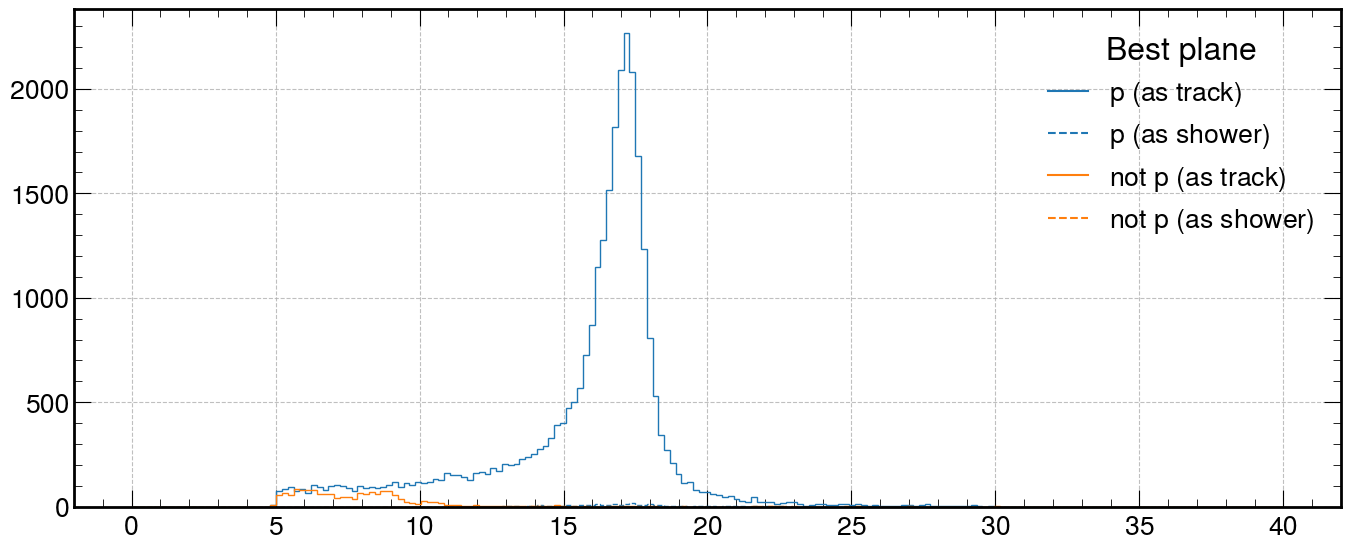

<Figure size 1400x600 with 0 Axes>

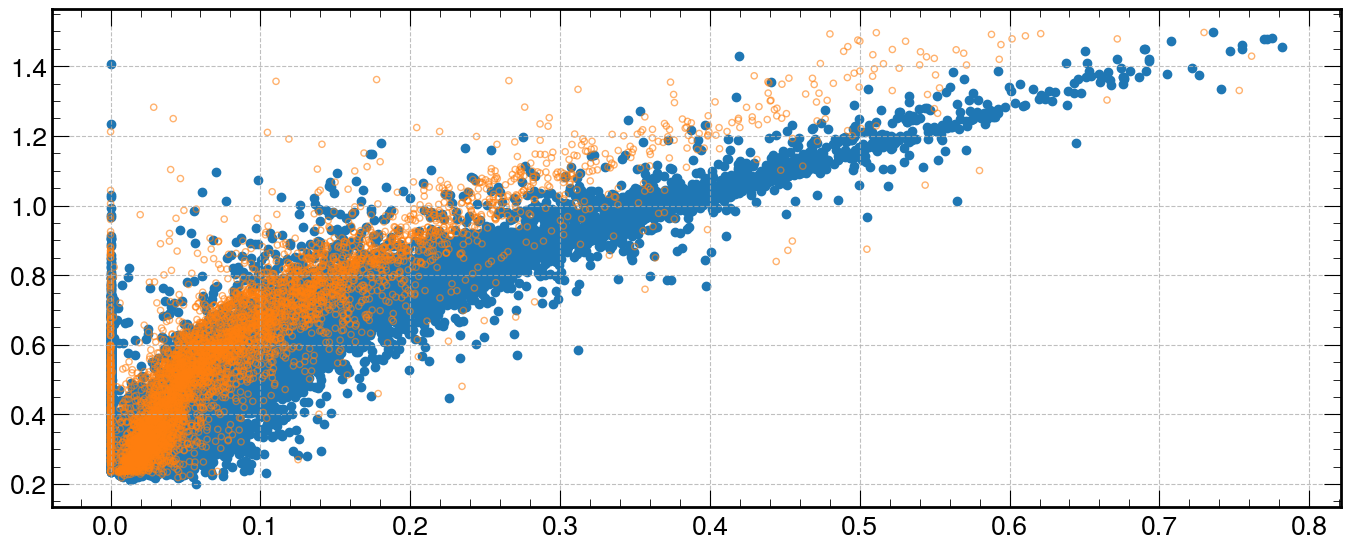

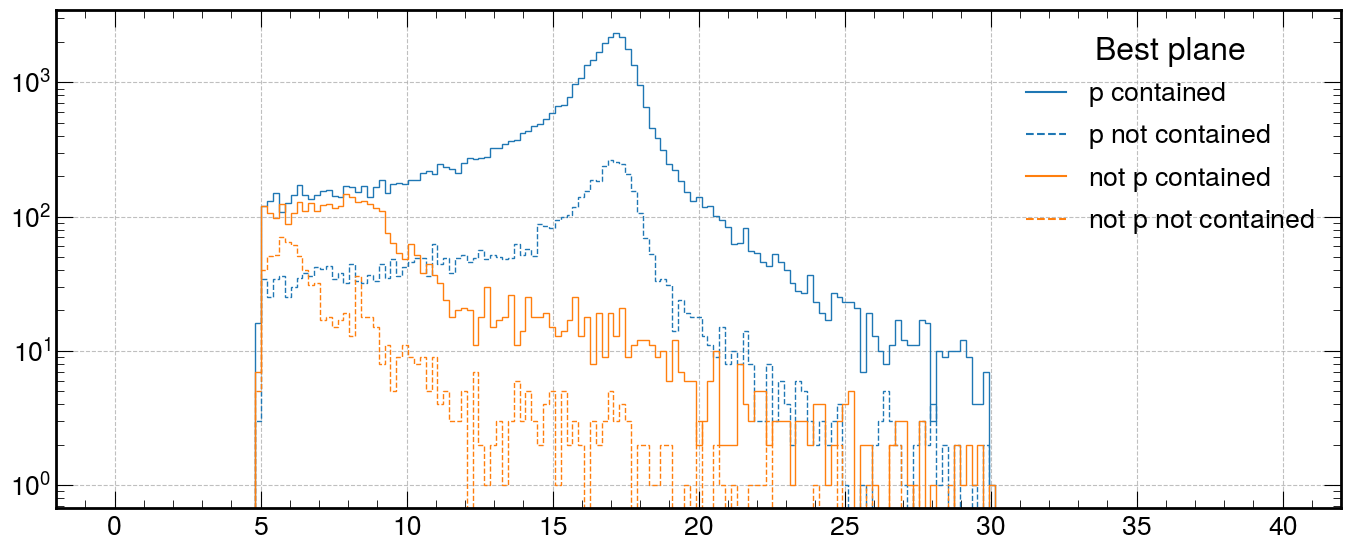

In [273]:
# This was done when I had only one option !
dftest = create_proton_candidate(dfprpi, return_easy=True, cut_pida_easy=5)
# dftest = dfprpi.join(dftest.group_by(selection_events()).agg(), on=selection_events())
plot_pid(dftest, 'B', threshold_pnc=0.81, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=0.81, ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=0.81, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=0.81, ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
# plt.yscale('log')


# Was used to see that moment by range needs to be smallter ...
# dftest = dftest.filter(
#     pl.col('trkPFPIsTrack'),
#     # pl.col('trkIsContained')
# )
# plt.figure()
# vy='trkmomrange_pr'
# vx='trkmomllhd'
# plt.scatter(dftest.filter(isproton()) [vx], dftest.filter(isproton())[vy])
# plt.scatter(dftest.filter(~isproton())[vx], dftest.filter(~isproton())[vy], alpha=0.6, s=20, color="C1", facecolor='none')
# plt.xlim(-2,5)
# # plt.xscale('log')
# # plt.yscale('log')

plt.figure()
# dftest = dftest.filter(
#     pl.col('trkmomllhd')<0,
#     pl.col('trkIsContained')
# )
vy='trkmomrange_pr'
vx='trkcalo_planes_B'
binscalo = np.linspace(-0.1,0.5,200)
binsmomrange = np.linspace(0.2, 1, 100)
plt.figure()
plt.scatter(dftest.filter(isproton()) [vx], dftest.filter(isproton())[vy])
plt.scatter(dftest.filter(~isproton())[vx], dftest.filter(~isproton())[vy], alpha=0.6, s=20, color="C1", facecolor='none')
# plt.xlim(-0.05,0.5)

# plt.figure()
# # plt.hist(dftest.filter(isproton()) [vx], bins=binsmomrange, histtype='step')
# # plt.hist(dftest.filter(~isproton())[vx], bins=binsmomrange, histtype='step');
# plt.hist2d(dftest.filter(isproton()) [vx], dftest.filter(isproton()) [vy], bins=[binscalo, binsmomrange], cmin=1, vmax=200);
# plt.colorbar()
# plt.figure()
# plt.hist2d(dftest.filter(~isproton())[vx], dftest.filter(~isproton())[vy], bins=[binscalo, binsmomrange], cmin=1, vmax=200);
# plt.colorbar()

plt.figure()
dftest_c = dftest.filter(pl.col('trkIsContained'))
dftest_notc = dftest.filter(~pl.col('trkIsContained'))
plot_pid(dftest_c, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, label=' contained')
plot_pid(dftest_notc, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, label=' not contained', ls='--', color='C0')
plot_pid(dftest_c, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, notthispdg=True, label=' contained', color='C1')
plot_pid(dftest_notc, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, notthispdg=True, label=' not contained', ls='--', color='C1')
plt.yscale('log')

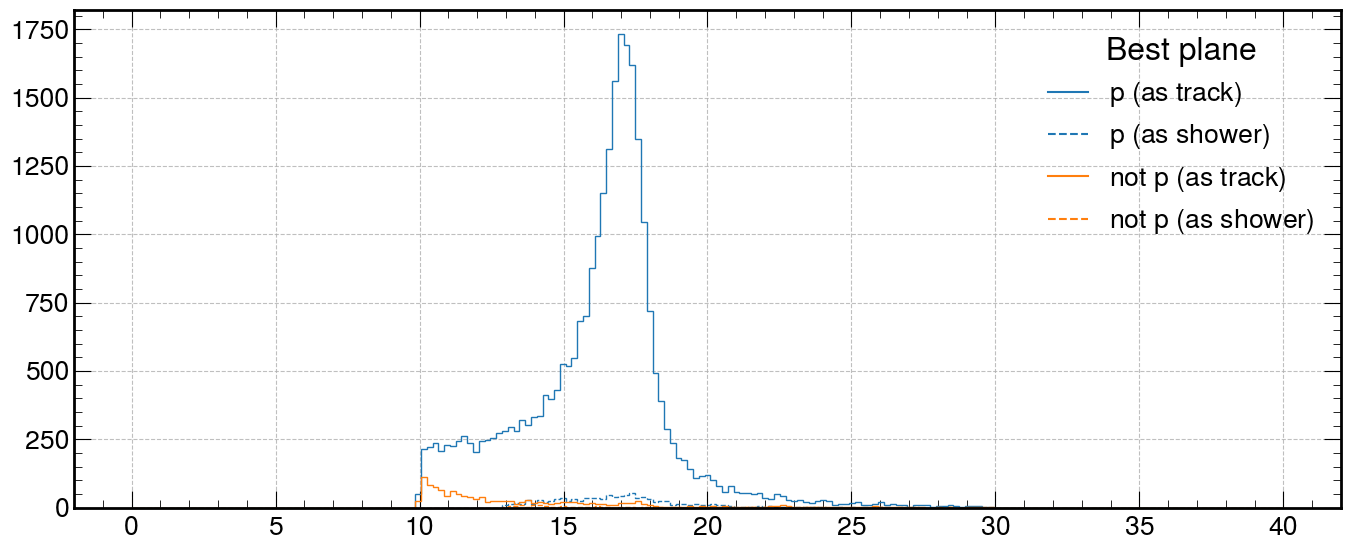

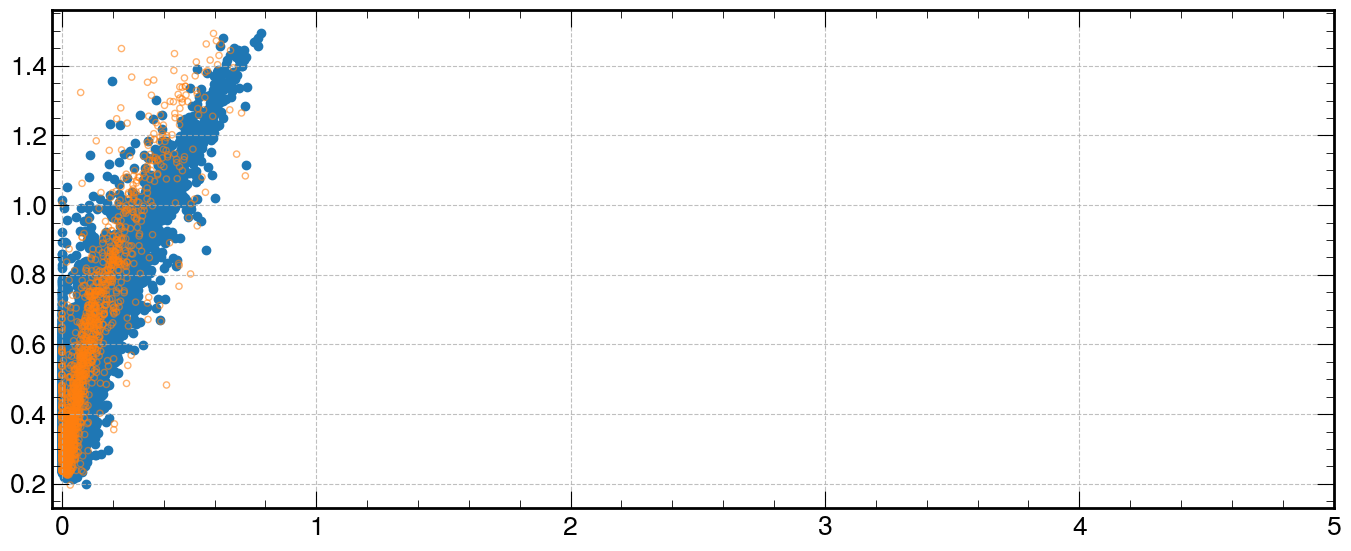

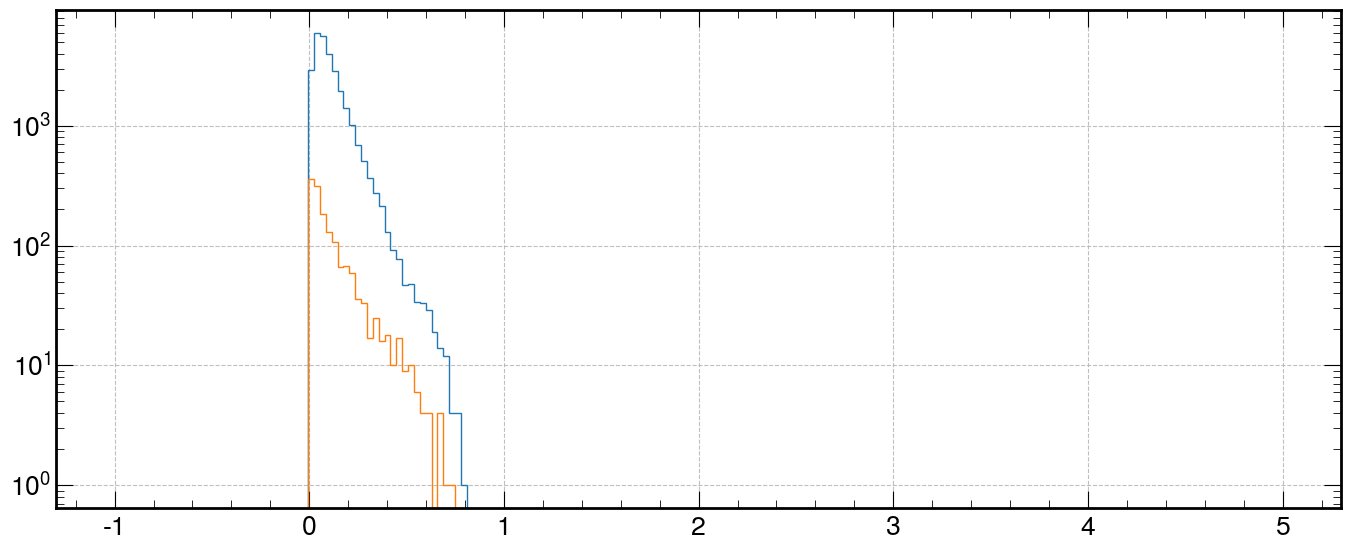

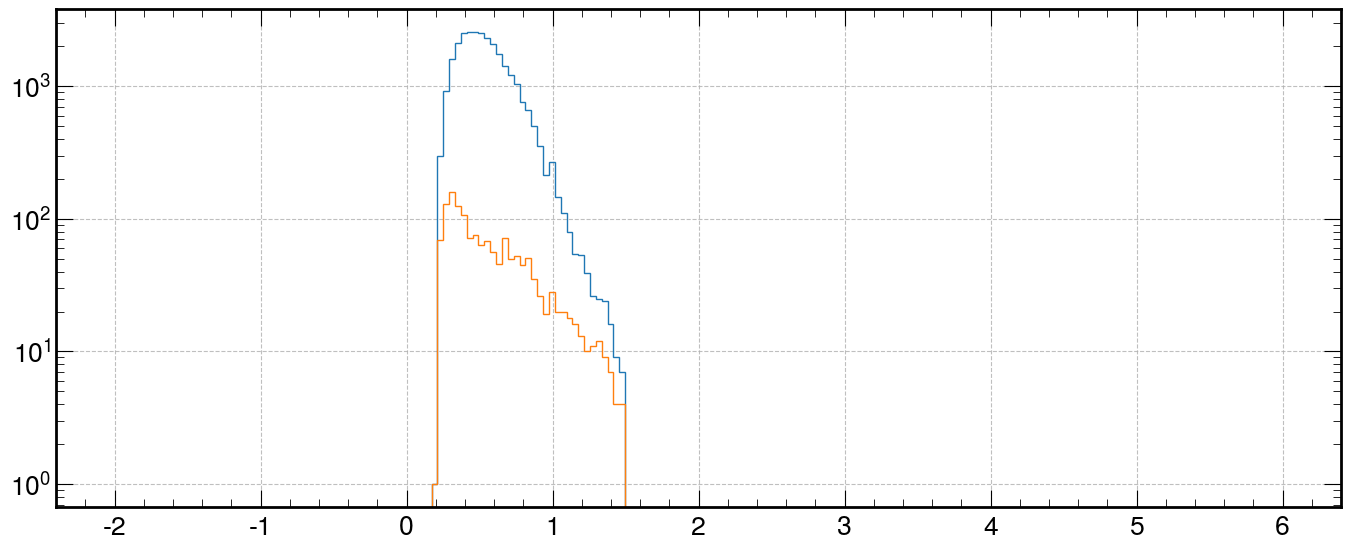

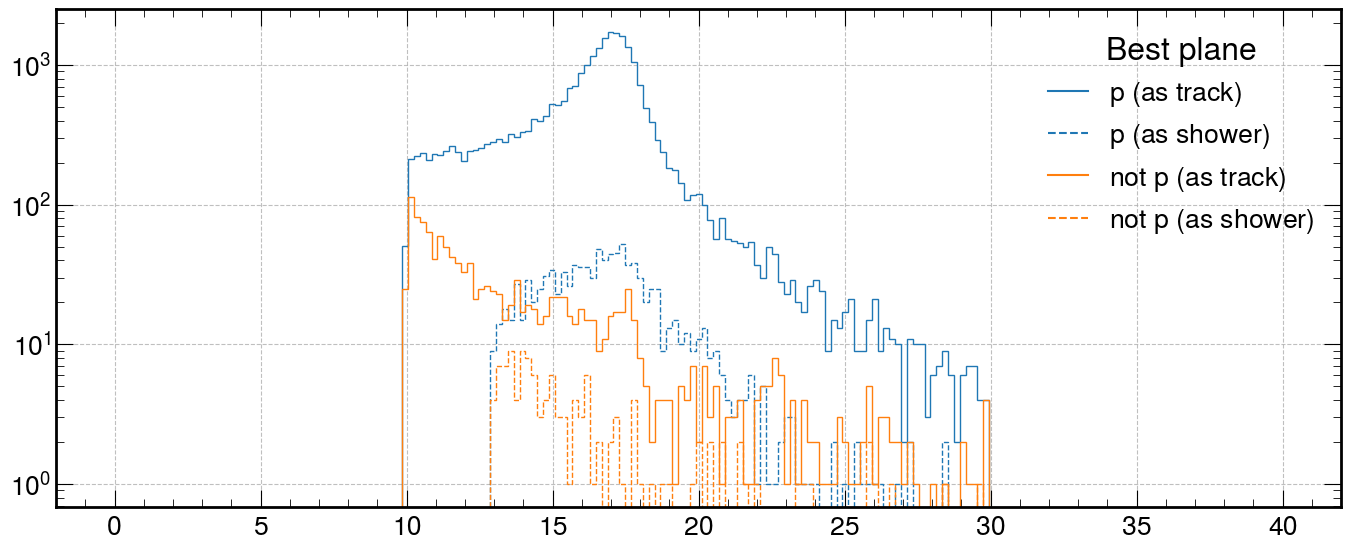

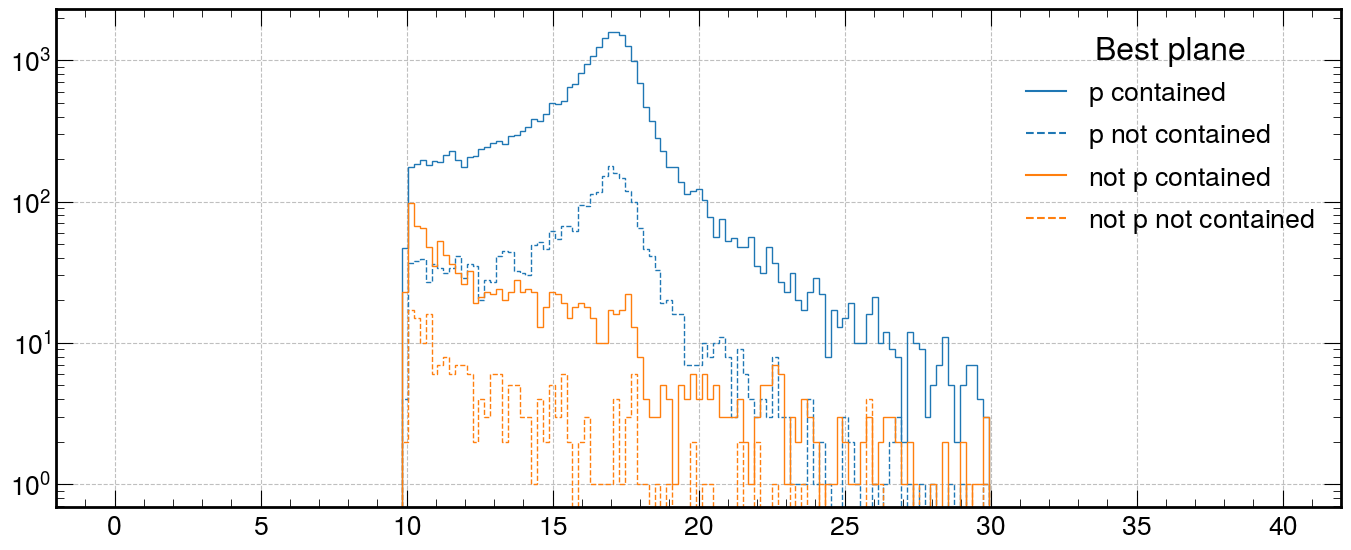

In [740]:
# This was done when we have 2 options!!
dftest = create_proton_candidate(dfprpi, return_second=True)

dftest = get_options(dftest)
# dftest = dftest.filter(~onlyone())
# dftest = dftest.sort('trkpidpida_B').group_by(selection_events(), maintain_order=True).agg(
#     pl.all().first()
# )

# # dftest = dfprpi.join(dftest.group_by(selection_events()).agg(), on=selection_events())
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
# plt.yscale('log')

plt.figure()
vy='trkmomrange_pr'
vx='trkcalo_planes_B'
plt.scatter(dftest.filter(isproton()) [vx], dftest.filter(isproton())[vy])
plt.scatter(dftest.filter(~isproton())[vx], dftest.filter(~isproton())[vy], alpha=0.6, s=20, color="C1", facecolor='none')
# plt.xlim(-0.05,0.5)
plt.xlim(None,5)
# plt.xscale('log')
plt.figure()
plt.hist(dftest.filter(isproton())[vx], bins=np.linspace(-1,5,200), histtype='step')
plt.hist(dftest.filter(~isproton())[vx], bins=np.linspace(-1,5,200), histtype='step')
plt.yscale('log')
plt.show()


plt.figure()
plt.hist(dftest.filter(isproton())[vy], bins=np.linspace(-2,6,200), histtype='step')
plt.hist(dftest.filter(~isproton())[vy], bins=np.linspace(-2,6,200), histtype='step')
plt.yscale('log')

dftest = dftest.filter(
    pl.col('trkcalo_planes_B')<0.8,
    pl.col('trkmomrange_pr')<1.5
)

dftest = get_options(dftest)

plt.figure()
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
plt.yscale('log')

plt.figure()
dftest_c = dftest.filter(pl.col('trkIsContained'))
dftest_notc = dftest.filter(~pl.col('trkIsContained'))
plot_pid(dftest_c, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, label=' contained')
plot_pid(dftest_notc, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, label=' not contained', ls='--', color='C0')
plot_pid(dftest_c, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, notthispdg=True, label=' contained', color='C1')
plot_pid(dftest_notc, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, notthispdg=True, label=' not contained', ls='--', color='C1')
plt.yscale('log')

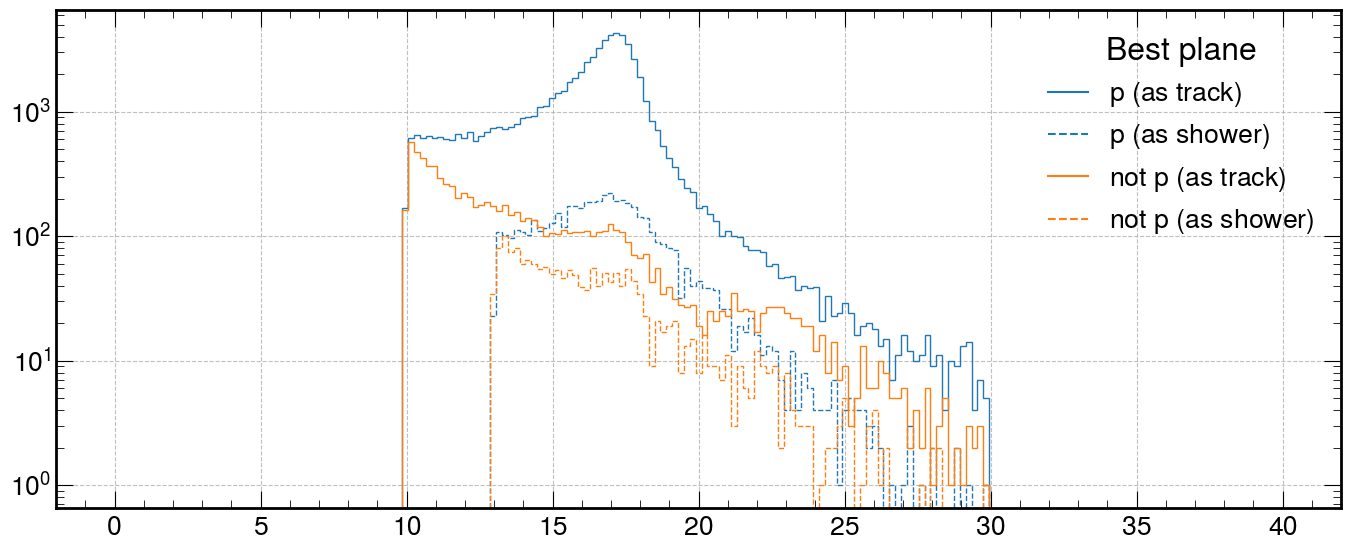

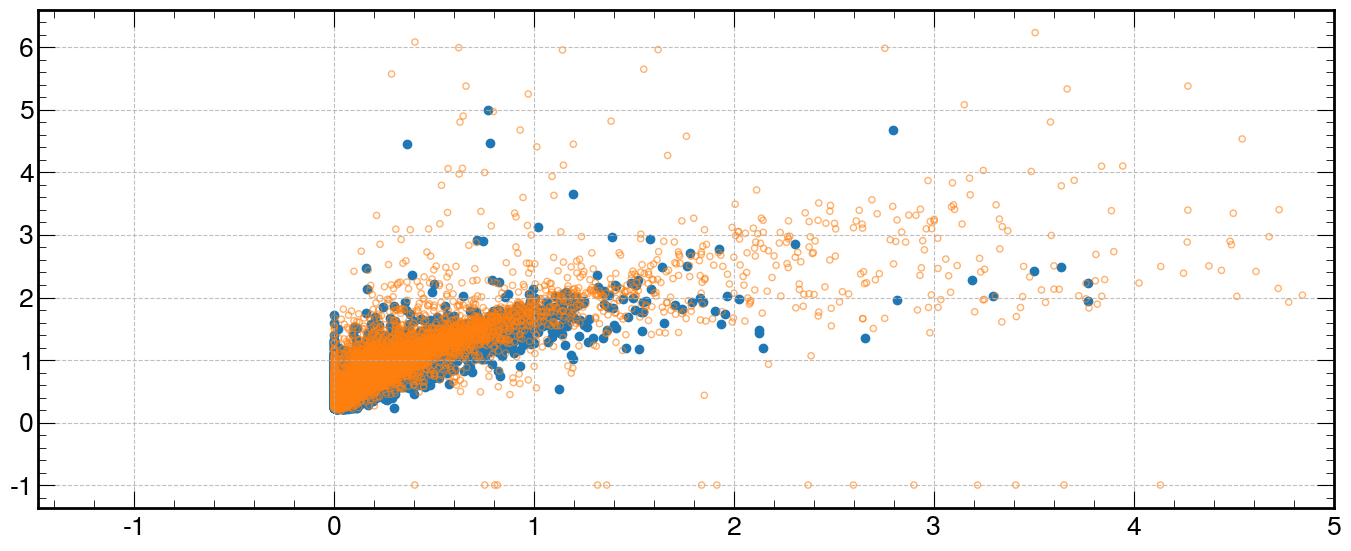

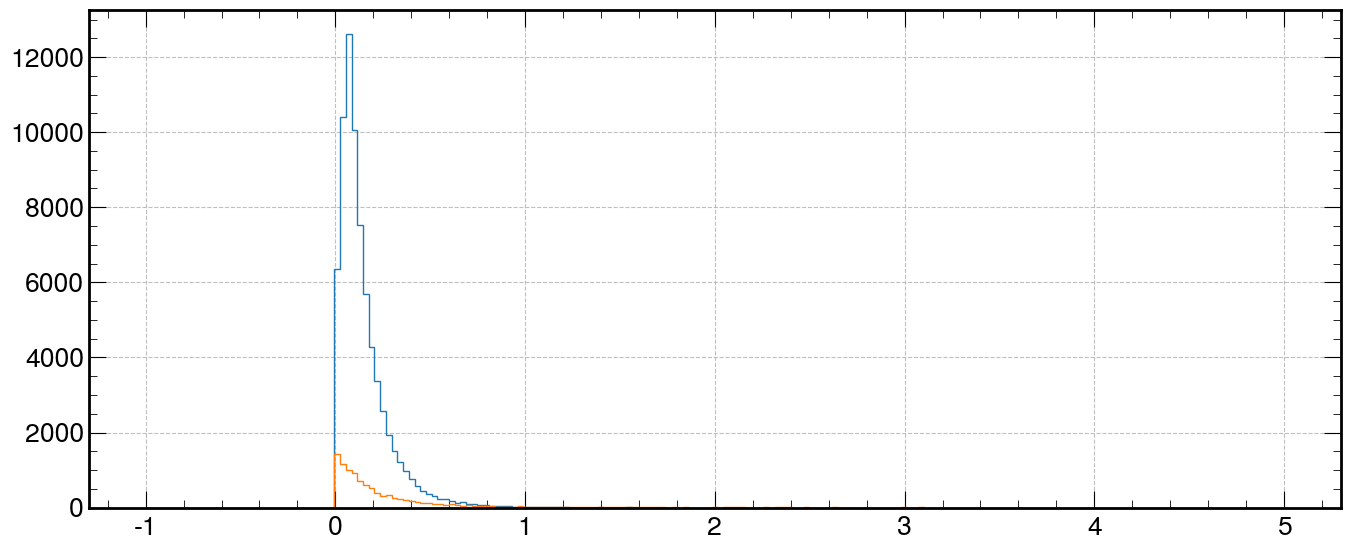

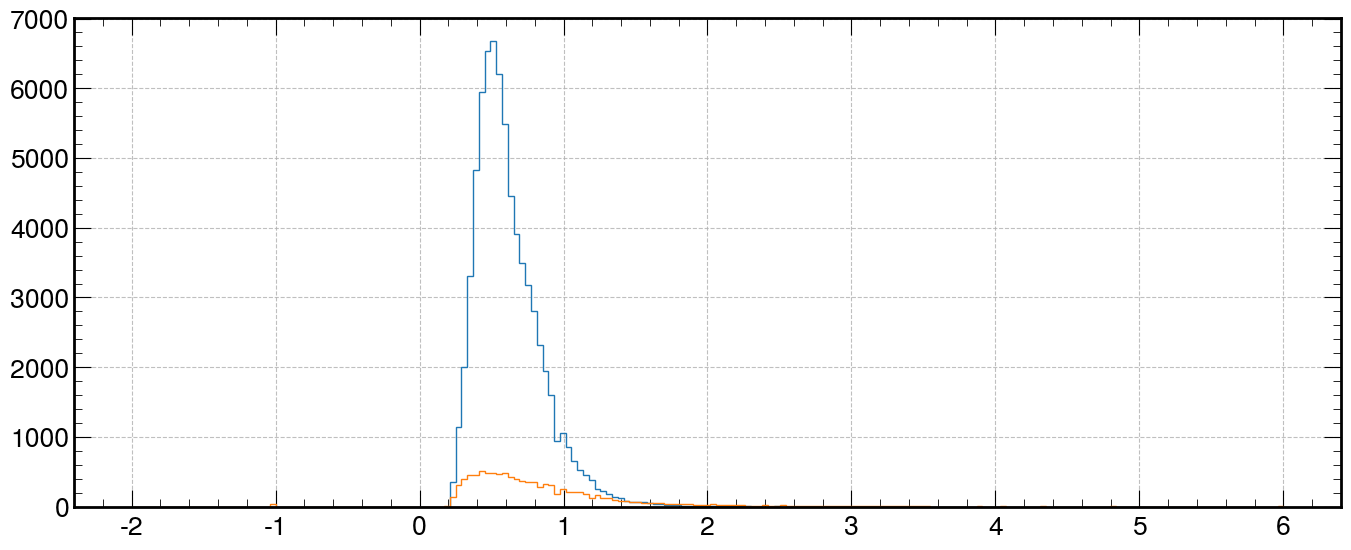

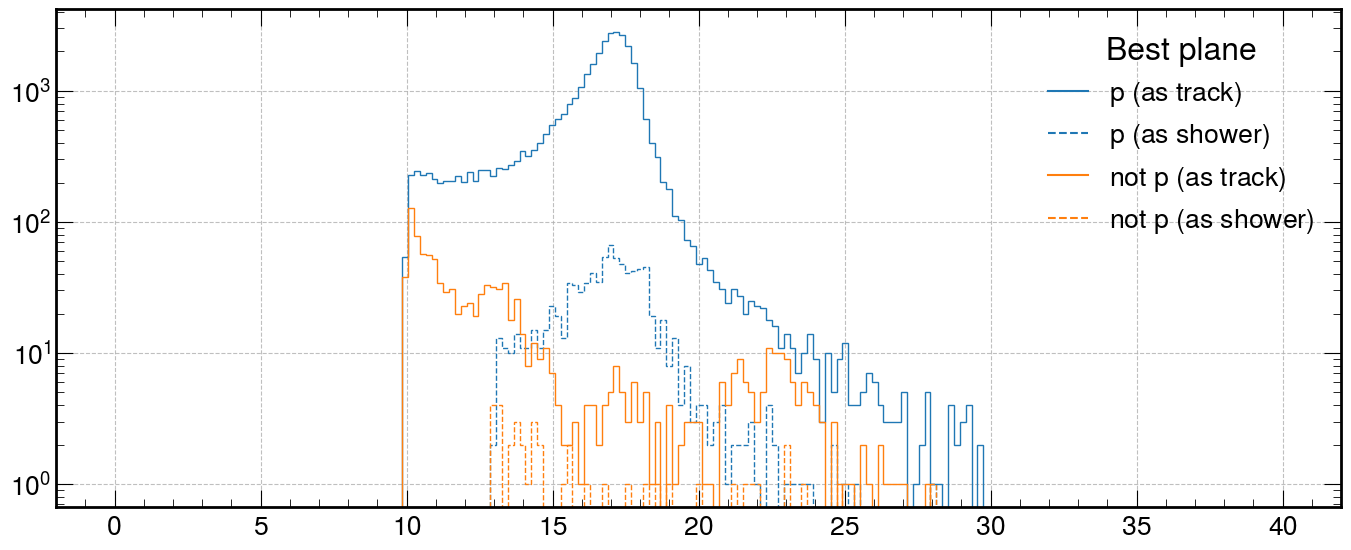

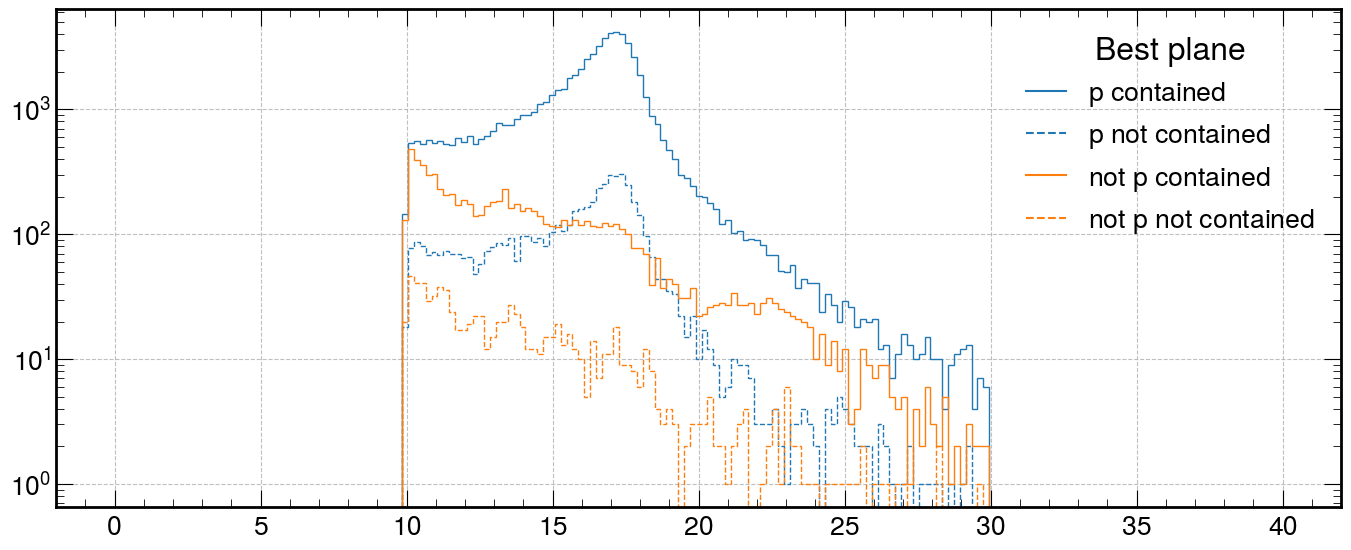

In [762]:
dftest = create_proton_candidate(dfprpi, return_last=True)
dftest = get_options(dftest)
dftest = dftest.filter(morethan())

# # dftest = dfprpi.join(dftest.group_by(selection_events()).agg(), on=selection_events())
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=0., ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
plt.yscale('log')

plt.figure()
vy='trkmomrange_pr'
vx='trkcalo_planes_B'
plt.scatter(dftest.filter(isproton()) [vx], dftest.filter(isproton())[vy])
plt.scatter(dftest.filter(~isproton())[vx], dftest.filter(~isproton())[vy], alpha=0.6, s=20, color="C1", facecolor='none')
# plt.xlim(-0.05,0.5)
plt.xlim(None,5)
# plt.xscale('log')
plt.figure()
plt.hist(dftest.filter(isproton())[vx], bins=np.linspace(-1,5,200), histtype='step')
plt.hist(dftest.filter(~isproton())[vx], bins=np.linspace(-1,5,200), histtype='step')
# plt.yscale('log')
plt.show()


plt.figure()
plt.hist(dftest.filter(isproton())[vy], bins=np.linspace(-2,6,200), histtype='step')
plt.hist(dftest.filter(~isproton())[vy], bins=np.linspace(-2,6,200), histtype='step')
# plt.yscale('log')

dftest = dftest.filter(
    pl.col('trkcalo_planes_B')<0.8,
    pl.col('trkmomrange_pr').is_between(0,1.5)
)

dftest = get_options(dftest)

plt.figure()
plot_pid(dftest, 'B', threshold_pnc=0.85, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=0.85, ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=0.85, ShowersAndTracks=False, onlyShower=False, onlycontained=False, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=0.85, ShowersAndTracks=True, onlyShower=True, onlycontained=False, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
plt.yscale('log')


plt.figure()
dftest_c = dftest.filter(pl.col('trkIsContained'))
dftest_notc = dftest.filter(~pl.col('trkIsContained'))
plot_pid(dftest_c, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, label=' contained')
plot_pid(dftest_notc, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, label=' not contained', ls='--', color='C0')
plot_pid(dftest_c, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, notthispdg=True, label=' contained', color='C1')
plot_pid(dftest_notc, 'B', threshold_pnc=0., ShowersAndTracks=True, onlycontained=False, pdg=2212, notthispdg=True, label=' not contained', ls='--', color='C1')
plt.yscale('log')

In [836]:
dftest_concat = create_proton_candidate(dfprpi, return_concat=True)
dftest = create_proton_candidate(dfprpi)


In [840]:
dftest

run,subrun,event,noptions,nuPDG_truth,ccnc_truth,mode_truth,nuWeight_truth,enu_truth,vtxx_truth,vtxy_truth,vtxz_truth,recovtxx,recovtxy,recovtxz,lepen,lepmass,leppdg,lepid,ntracks,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4mother,trknhits,trkg4id_planes_U,trkg4id_planes_V,…,trkpidchi2mu_W,trkpidndf_U,trkpidndf_V,trkpidndf_W,trkpidpida_U,trkpidpida_V,trkpidpida_W,allcalo_planes_U,allcalo_planes_V,allcalo_planes_W,nallhits_planes_U,nallhits_planes_V,nallhits_planes_W,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4mother_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trktotalen_planes_B,trkpartialen_planes_B,trkpidchi2ndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidndf_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B,pnc,candidate,selected_mu
i32,i32,i32,u32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,i32,i32,i32,i32,…,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,f32,f32,i32,f32,f32,i32,i32,f32,f32,f32,i32,f32,f32,f32,f32,i32,f32,f32,i32,f32,bool,bool
1453,1,7,1,14,0,0,4.3267324e7,0.426803,250.674133,-368.723816,598.395813,251.023544,-368.271179,598.295593,0.303388,0.105658,13,5,3,1,251.072372,-368.663849,598.294739,258.43219,-372.97821,595.891174,0.954545,0.875,3,2212,1.049998,0.938272,0,22,3,3,…,45.057171,3,9,4,2.154617,16.353777,17.526615,0.252083,0.189633,0.267613,122,55,49,3,2212,1.049998,0.938272,0,0.909091,1.0,11,10,0.054233,92.896851,92.896851,9,6.196791,8.680071,34.953499,41.607063,9,16.353777,0.252083,55,0.909091,false,false
1453,1,11,1,14,0,10,5.0760664e7,1.032649,360.359467,542.612366,455.687866,359.834351,541.876648,455.400513,0.512931,0.105658,13,4,3,1,359.120239,542.514526,454.553192,362.646729,540.081604,457.591064,0.769231,0.714286,4,2212,1.04477,0.938272,0,13,4,-1,…,30.583971,6,-1,2,10.526516,-1.0,15.415747,0.470528,0.190995,0.483347,316,87,197,4,2212,1.04477,0.938272,0,0.666667,0.857143,9,6,0.043065,80.86348,80.86348,6,68.116959,26.76425,12.238693,12.654329,6,10.526516,0.470528,316,0.571429,false,false
1453,1,16,1,14,0,0,4.2340764e7,0.3587,-331.284821,-579.747009,508.262421,-331.528564,-579.297058,508.633667,0.239875,0.105658,13,4,2,1,-331.403168,-580.102051,508.120422,-338.484039,-577.506714,506.878906,0.956522,1.0,2,2212,1.037424,0.938272,0,23,2,2,…,29.658787,4,7,2,0.565455,10.888078,14.03186,0.094129,0.124894,0.128746,51,38,19,2,2212,1.037424,0.938272,0,1.0,1.0,10,10,0.025197,19.225119,19.225119,7,95.633377,62.56094,28.381151,31.268402,7,10.888078,0.094129,51,1.0,false,false
1453,1,52,1,14,0,0,4.6149924e7,0.593069,-31.407276,-151.047134,58.251003,-31.307554,-151.442993,58.334072,0.23402,0.105658,13,5,2,0,-31.177879,-150.913116,58.324699,-49.016819,-197.843124,80.210159,0.964497,1.0,3,2212,1.248085,0.938272,0,169,3,3,…,45.41494,12,51,24,13.443256,17.58659,17.888145,0.379661,0.399106,0.400838,64,164,75,3,2212,1.248085,0.938272,0,0.979592,1.0,98,96,0.259143,296.595215,95.383087,43,4.451202,13.605581,41.007267,44.432217,51,17.58659,0.399106,164,0.979592,false,false
1453,1,60,1,14,0,0,6.1252944e7,0.659363,271.295776,-457.908295,633.843628,271.247589,-458.350128,633.523438,0.390706,0.105658,13,5,2,1,271.039581,-458.146698,633.619629,300.268616,-442.264008,657.543152,0.966216,1.0,3,2212,1.196253,0.938272,0,148,3,3,…,45.443623,24,45,36,9.102968,16.956839,17.351692,0.484732,0.492315,0.509491,159,237,94,3,2212,1.196253,0.938272,0,0.96875,1.0,64,62,0.21104,247.532806,102.420052,39,4.630257,11.515345,38.038715,42.76115,45,16.956839,0.492315,237,0.96875,false,false
1453,1,62,1,14,0,10,3.5143304e7,6.05666,312.206177,-45.308624,1128.695801,312.526123,-45.906166,1128.533081,5.485924,0.105658,13,4,2,1,311.624756,-44.896198,1127.857056,315.97522,-53.047794,1134.39917,0.594595,0.785714,6,2212,1.031272,0.938272,4,37,6,-1,…,13.685321,17,-1,10,17.